<a href="https://colab.research.google.com/github/ANUNAYBAGGA/Stock-Reserch/blob/main/StocksAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sympy import *

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:


path = 'gdrive/My Drive/stonks_DB'
extension = 'csv'
os.chdir(path) #Use for first time only
result = glob.glob('*.{}'.format(extension))
print(result)
db = {}
for i in result:
  db[i[:-4]] = pd.read_csv(i)

print(db.keys())
stocks = list(db.keys())

['ONGC.csv', 'GAIL.csv', 'MARUTI.csv', 'HEROMOTOCO.csv', 'NESTLEIND.csv', 'ULTRACEMCO.csv', 'HINDUNILVR.csv', 'IOC.csv', 'LT.csv', 'RELIANCE.csv', 'BPCL.csv', 'ADANIPORTS.csv', 'BAJFINANCE.csv', 'M&M.csv', 'INFY.csv', 'TCS.csv', 'NTPC.csv', 'HDFC.csv', 'JSWSTEEL.csv', 'HCLTECH.csv', 'POWERGRID.csv', 'SBIN.csv', 'SHREECEM.csv', 'TATASTEEL.csv', 'HINDALCO.csv', 'UPL.csv']
dict_keys(['ONGC', 'GAIL', 'MARUTI', 'HEROMOTOCO', 'NESTLEIND', 'ULTRACEMCO', 'HINDUNILVR', 'IOC', 'LT', 'RELIANCE', 'BPCL', 'ADANIPORTS', 'BAJFINANCE', 'M&M', 'INFY', 'TCS', 'NTPC', 'HDFC', 'JSWSTEEL', 'HCLTECH', 'POWERGRID', 'SBIN', 'SHREECEM', 'TATASTEEL', 'HINDALCO', 'UPL'])


In [4]:
#Weekly
def shift_returns(shift):
  days_to_shift = shift
  print(db.keys())
  for i in db.keys():
    shifted_db = db[i].shift(days_to_shift)
    returns = shifted_db['adjusted_close'] - db[i]['adjusted_close']
    log_returns = np.log(shifted_db['adjusted_close'] / db[i]['adjusted_close'])
    db[i]['return'] = returns
    db[i]['log_return'] = log_returns
shift_returns(5)

dict_keys(['ONGC', 'GAIL', 'MARUTI', 'HEROMOTOCO', 'NESTLEIND', 'ULTRACEMCO', 'HINDUNILVR', 'IOC', 'LT', 'RELIANCE', 'BPCL', 'ADANIPORTS', 'BAJFINANCE', 'M&M', 'INFY', 'TCS', 'NTPC', 'HDFC', 'JSWSTEEL', 'HCLTECH', 'POWERGRID', 'SBIN', 'SHREECEM', 'TATASTEEL', 'HINDALCO', 'UPL'])


In [5]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

days = 364
for stock in stocks:
  print()
  print(stock , " ******************************")
  print(db[stock][1:].describe())
 
  fig = go.Figure(data=[go.Candlestick(x=db[stock][:days]['timestamp'],
                  open=db[stock][:days]['open'],
                  high=db[stock][:days]['high'],
                  low=db[stock][:days]['low'],
                  close=db[stock][:days]['close'])])

  fig.show()


ONGC  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    532.798617   540.785115  ...     0.081104     0.001044
std     412.154236   418.704967  ...     5.567518     0.048215
min      60.000000    63.000000  ...   -32.513700    -0.394218
25%     197.000000   198.362500  ...    -2.955425    -0.025391
50%     297.575100   302.950150  ...     0.117750     0.001122
75%     925.000200   938.125350  ...     3.132125     0.028121
max    1479.999600  1513.999200  ...    43.572300     0.256204

[8 rows x 10 columns]



GAIL  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    334.891067   339.699027  ...     0.146385     0.002025
std     104.548100   105.782269  ...     3.976848     0.045954
min      69.200000    72.250000  ...   -29.168300    -0.322752
25%     276.000000   279.999800  ...    -1.855525    -0.023924
50%     352.100000   357.000000  ...     0.116300     0.001933
75%     410.000000   416.062550  ...     2.142100     0.028401
max     549.899800   551.350200  ...    19.584000     0.213832

[8 rows x 10 columns]



MARUTI  ******************************
              open          high  ...       return   log_return
count  3984.000000   3984.000000  ...  3980.000000  3980.000000
mean   3136.550301   3173.483798  ...     8.470185     0.003606
std    2743.768682   2768.457988  ...   160.505011     0.047416
min     397.000000    407.000000  ... -1263.535600    -0.264379
25%     953.975000    967.837500  ...   -38.555175    -0.022495
50%    1500.000000   1519.750000  ...     7.792850     0.004960
75%    5600.750000   5664.037500  ...    54.873100     0.031932
max    9970.000000  10000.000000  ...  1074.089500     0.239136

[8 rows x 10 columns]



HEROMOTOCO  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean   2016.353188  2041.854932  ...     3.856455     0.002846
std     970.052961   977.823665  ...    72.875499     0.041359
min     485.000000   509.600000  ...  -396.337400    -0.192014
25%     899.875000   909.675000  ...   -29.307950    -0.021591
50%    1970.525000  2002.000000  ...     2.148300     0.002395
75%    2749.325000  2788.887500  ...    34.843975     0.027268
max    4200.000000  4200.000000  ...   389.219800     0.223946

[8 rows x 10 columns]



NESTLEIND  ******************************
               open          high  ...       return   log_return
count   3984.000000   3984.000000  ...  3980.000000  3980.000000
mean    5513.854153   5574.233510  ...    20.269262     0.004501
std     4418.432424   4462.359844  ...   238.540782     0.035894
min      525.250000    553.000000  ... -2513.408300    -0.187125
25%     1678.750000   1699.950000  ...   -52.334275    -0.016105
50%     4726.500000   4770.500000  ...     7.261250     0.003197
75%     6799.925000   6860.000000  ...    86.497175     0.024553
max    18721.000000  18821.400400  ...  2717.228800     0.192702

[8 rows x 10 columns]



ULTRACEMCO  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean   2155.945821  2184.552046  ...     7.860982     0.003811
std    1465.739848  1480.891052  ...   104.172455     0.046711
min     259.750000   266.000000  ...  -684.491600    -0.219558
25%     875.000000   891.662500  ...   -32.482400    -0.020953
50%    1793.150000  1822.050000  ...     4.257450     0.003637
75%    3674.000000  3724.175000  ...    44.236375     0.029827
max    6470.000000  6830.399900  ...  1027.049800     0.223216

[8 rows x 10 columns]



HINDUNILVR  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    749.874134   757.824862  ...     2.615543     0.003860
std     633.398108   639.612141  ...    31.986586     0.038027
min     127.000000   129.500000  ...  -275.677700    -0.189739
25%     244.500000   248.900000  ...    -6.864225    -0.017059
50%     529.350000   533.600000  ...     0.976500     0.002678
75%     927.000000   935.125000  ...     9.832175     0.024407
max    2500.000000  2614.000000  ...   373.941100     0.209049

[8 rows x 10 columns]



IOC  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    340.103967   345.356116  ...     0.083894     0.001344
std     136.505147   139.196171  ...     3.475052     0.051346
min      72.000000    73.450000  ...   -28.699600    -0.415825
25%     257.775000   260.000000  ...    -1.513875    -0.026463
50%     354.925000   360.050000  ...     0.049150     0.001114
75%     429.912500   436.000000  ...     1.617600     0.028883
max     794.000000   809.900000  ...    24.901600     0.248268

[8 rows x 10 columns]



LT  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean   1561.081754  1583.424997  ...     1.744261     0.003546
std     586.476190   598.764158  ...    34.894982     0.051799
min     565.099100   581.999000  ...  -234.973300    -0.312481
25%    1269.997700  1284.999375  ...   -15.438125    -0.022783
50%    1454.997200  1470.622200  ...     1.628700     0.003131
75%    1675.159475  1696.848000  ...    17.470700     0.030971
max    4500.091400  4669.991100  ...   221.687700     0.335457

[8 rows x 10 columns]



RELIANCE  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean   1195.521930  1212.511318  ...     2.595814     0.004041
std     512.438304   523.556449  ...    34.435202     0.046468
min     377.517600   381.517300  ...  -273.905400    -0.293369
25%     874.037225   884.299625  ...    -9.891275    -0.020890
50%    1021.349700  1033.524650  ...     1.802600     0.004439
75%    1363.599525  1379.599600  ...    13.375950     0.029024
max    3215.999200  3252.099100  ...   241.450200     0.359763

[8 rows x 10 columns]



BPCL  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    500.368923   508.347253  ...     0.524358     0.002910
std     171.868501   173.584838  ...    11.086016     0.054165
min     217.999800   229.099800  ...   -96.837700    -0.360365
25%     363.999600   369.999600  ...    -2.547525    -0.026280
50%     434.999400   443.249550  ...     0.194450     0.002182
75%     625.062000   634.861800  ...     3.302275     0.032132
max    1138.698900  1152.448800  ...    91.510000     0.234564

[8 rows x 10 columns]



ADANIPORTS  ******************************
              open         high  ...       return   log_return
count  3264.000000  3264.000000  ...  3260.000000  3260.000000
mean    341.094638   347.598775  ...     0.852307     0.002206
std     190.281387   195.247137  ...    13.191820     0.060204
min     107.750000   110.000000  ...   -76.218100    -0.359173
25%     163.437500   166.887500  ...    -5.700375    -0.028979
50%     324.500000   329.725000  ...     0.690250     0.003832
75%     399.950000   405.000000  ...     7.419975     0.035765
max    1310.000000  1324.000000  ...    78.600000     0.272254

[8 rows x 10 columns]



BAJFINANCE  ******************************
               open          high  ...       return   log_return
count   3983.000000   3983.000000  ...  3979.000000  3979.000000
mean    1785.989336   1815.413907  ...     6.786304     0.007953
std     1913.661689   1943.413967  ...    90.946074     0.064129
min       43.450000     50.500000  ... -1410.600000    -0.484235
25%      390.400000    397.000000  ...    -1.720400    -0.023124
50%     1078.250000   1095.000000  ...     0.427000     0.007102
75%     2583.500000   2614.500000  ...     6.404250     0.039209
max    11268.950000  11760.050000  ...   802.800000     0.339030

[8 rows x 10 columns]



M&M  ******************************
              open         high  ...       return   log_return
count  5369.000000  5369.000000  ...  5365.000000  5365.000000
mean     36.077191    36.596655  ...     0.001794     0.000125
std      16.275021    16.374762  ...     1.065577     0.064502
min       4.500000     4.865000  ...    -7.520150    -0.435125
25%      24.150000    24.550000  ...    -0.556514    -0.029705
50%      35.910000    36.380000  ...     0.043512     0.002522
75%      44.880000    45.440000  ...     0.582683     0.032110
max      78.800000    79.390000  ...     5.390000     0.404942

[8 rows x 10 columns]



INFY  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean   1918.938013  1941.349551  ...     1.528854     0.003291
std     871.967105   880.471389  ...    17.077498     0.040908
min     530.000000   557.700000  ...  -152.660800    -0.247278
25%    1100.000000  1114.800000  ...    -5.028825    -0.016730
50%    1952.550000  1972.000000  ...     1.356050     0.004899
75%    2666.000000  2697.012800  ...     7.550125     0.025692
max    4388.000000  4401.000000  ...   151.870200     0.186543

[8 rows x 10 columns]



TCS  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean   1695.138545  1715.024339  ...     3.619670     0.003959
std     717.547831   722.477665  ...    39.792886     0.040847
min     360.000000   377.000000  ...  -412.101200    -0.249191
25%    1108.000000  1121.000000  ...    -9.952200    -0.019216
50%    1668.500000  1691.700000  ...     1.932950     0.003963
75%    2322.250000  2343.462500  ...    14.860600     0.027573
max    3619.000000  3674.000000  ...   331.254100     0.227351

[8 rows x 10 columns]



NTPC  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    152.379613   154.337645  ...     0.082755     0.001137
std      35.293436    35.821365  ...     4.140522     0.041145
min      76.000000    78.700000  ...   -44.398800    -0.331447
25%     130.999900   132.700000  ...    -1.969325    -0.020143
50%     153.374950   155.350000  ...     0.053050     0.000541
75%     172.999900   175.512400  ...     2.196825     0.023414
max     289.999900   290.999900  ...    21.135400     0.195694

[8 rows x 10 columns]



HDFC  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean   1502.945357  1524.876707  ...     3.102372     0.003851
std     658.561687   670.272028  ...    45.503806     0.047058
min     589.900000   601.500000  ...  -407.705700    -0.274700
25%     866.250000   879.337500  ...   -14.566775    -0.021322
50%    1377.550000  1395.000000  ...     2.532900     0.004333
75%    1953.750000  1979.837500  ...    20.268000     0.030056
max    3200.000000  3257.000000  ...   343.500000     0.324570

[8 rows x 10 columns]



JSWSTEEL  ******************************
              open         high  ...       return   log_return
count  3962.000000  3962.000000  ...  3958.000000  3958.000000
mean    657.956032   669.604455  ...     0.483603     0.003290
std     399.866374   405.603714  ...     7.615591     0.069305
min      14.100000    14.700000  ...   -59.036600    -0.495220
25%     285.000000   289.725000  ...    -2.681575    -0.032293
50%     635.000000   652.425000  ...     0.330250     0.004511
75%     947.375000   964.875000  ...     3.686225     0.041098
max    1868.000000  1886.500000  ...    56.326100     0.523888

[8 rows x 10 columns]



HCLTECH  ******************************
              open        high  ...       return   log_return
count  3984.000000  3984.00000  ...  3980.000000  3980.000000
mean    689.356272   698.78387  ...     1.154501     0.004312
std     367.912136   371.50524  ...    12.810716     0.048540
min      91.700000    94.00000  ...  -113.840400    -0.236807
25%     393.600000   399.30000  ...    -2.795175    -0.021427
50%     617.875000   625.00000  ...     0.648250     0.004666
75%     916.000000   928.85000  ...     4.629875     0.031023
max    2068.000000  2116.40000  ...    91.260200     0.263117

[8 rows x 10 columns]



POWERGRID  ******************************
              open         high  ...       return   log_return
count  3300.000000  3300.000000  ...  3296.000000  3296.000000
mean    140.735742   142.512015  ...     0.229007     0.001688
std      41.587629    41.845182  ...     4.305141     0.039763
min      60.050000    62.000000  ...   -29.732100    -0.334960
25%     104.287500   105.587500  ...    -1.834925    -0.016877
50%     132.625000   134.000000  ...     0.038600     0.000268
75%     184.512500   186.775000  ...     2.189150     0.020256
max     239.000000   239.000000  ...    24.420700     0.285372

[8 rows x 10 columns]



SBIN  ******************************
              open         high  ...       return   log_return
count  4098.000000  4098.000000  ...  4094.000000  4094.000000
mean    237.448368   240.325828  ...     0.469624     0.004466
std     244.371213   244.476453  ...    12.635202     0.136247
min      53.318400    54.724200  ...  -230.318000    -2.278467
25%     164.225000   166.918750  ...    -3.400000    -0.026830
50%     220.515000   223.500000  ...     0.236500     0.003563
75%     269.987500   272.662500  ...     3.926800     0.033993
max    3455.000000  3497.000100  ...   238.157000     2.337826

[8 rows x 10 columns]



SHREECEM  ******************************
               open          high  ...       return   log_return
count   3984.000000   3984.000000  ...  3980.000000  3980.000000
mean    7891.895182   8005.956916  ...    34.763609     0.005938
std     7721.033659   7823.055477  ...   473.384045     0.051756
min      257.800000    259.000000  ... -3159.650000    -0.243449
25%     1366.250000   1398.637500  ...   -70.711250    -0.023642
50%     4191.500000   4250.000000  ...     9.604250     0.004601
75%    16026.250000  16223.612500  ...   117.968050     0.035015
max    28610.000000  29097.550800  ...  4083.300800     0.277935

[8 rows x 10 columns]



TATASTEEL  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    469.563707   477.351130  ...     0.675593     0.001601
std     147.839472   150.285838  ...    22.018609     0.063323
min     148.000000   151.500000  ...  -125.124700    -0.422479
25%     367.737500   372.499975  ...   -11.079100    -0.033990
50%     455.825050   463.750100  ...     0.831550     0.002507
75%     567.525000   576.000000  ...    12.996025     0.037503
max     997.699800  1048.799800  ...   111.344700     0.380144

[8 rows x 10 columns]



HINDALCO  ******************************
             open         high  ...       return   log_return
count  3984.00000  3984.000000  ...  3980.000000  3980.000000
mean    204.85011   208.141399  ...     0.310299     0.001563
std     231.43231   233.924191  ...     8.653251     0.064049
min      36.90000    38.250000  ...   -42.164400    -0.482453
25%     122.40000   124.237500  ...    -4.826125    -0.036366
50%     160.00000   163.075000  ...     0.363250     0.002995
75%     198.00000   201.000000  ...     5.382675     0.040434
max    1464.99970  1486.999200  ...    41.000000     0.416950

[8 rows x 10 columns]



UPL  ******************************
              open         high  ...       return   log_return
count  3984.000000  3984.000000  ...  3980.000000  3980.000000
mean    392.333237   398.913665  ...     0.701352     0.003348
std     244.847655   247.816024  ...    14.793964     0.058280
min      73.350000    76.250100  ...  -192.709400    -0.473881
25%     164.875100   167.762600  ...    -3.898000    -0.028159
50%     325.000200   331.850200  ...     0.425100     0.003879
75%     582.000075   590.837500  ...     5.491850     0.034813
max    1045.000500  1045.000500  ...    84.700000     0.397745

[8 rows x 10 columns]


Momentum Based Trading System.
Choose the top and bottom performers and then long and short them respectively.

In [6]:
#Momentum Trading
days = 365

print(db['ONGC'].head(10))
table = []
for i in range(days):
  signal = [0 for i in range(len(stocks))]
  order = [db[x]['log_return'][i] for x in stocks]
  order = pd.DataFrame(order).nlargest(3,0).index
  for x in order:
    signal[x] = 1
  table.append(signal)
table = pd.DataFrame(table , columns = stocks)
#print(table)

count = [table[stock].value_counts()[1] for stock in stocks]
count = pd.DataFrame(count)
long_momentum = [stocks[x] for x in count.nlargest(3,0).index]
short_momentum = [stocks[x] for x in count.nsmallest(3,0).index]
print("Score for each stock : ")
#print(count)
map = {}
for i in range(len(stocks)):
  map[count[0][i]] = map.get(count[0][i] , []) + [stocks[i]]
tmp = list(map.keys())
tmp.sort()
tmp.reverse()
map_movement = {}
for i in tmp:
  print(map[i] , " : ", i/days)
  map_movement[map[i][0]] = i/days

print("Rising stocks, Top stocks to long are  : " , long_momentum)
print("Dropping stocks, Top stocks to short are : ", short_momentum)
print(map_movement)

    timestamp    open    high  ...  split_coefficient  return  log_return
0  2021-03-05  116.25  118.20  ...                1.0     NaN         NaN
1  2021-03-04  113.80  117.05  ...                1.0     NaN         NaN
2  2021-03-03  114.45  115.90  ...                1.0     NaN         NaN
3  2021-03-02  116.00  116.65  ...                1.0     NaN         NaN
4  2021-03-01  114.40  117.50  ...                1.0     NaN         NaN
5  2021-02-26  115.90  118.40  ...                1.0    3.75    0.033182
6  2021-02-25  115.60  120.50  ...                1.0   -6.30   -0.054394
7  2021-02-24  113.80  115.50  ...                1.0    0.30    0.002636
8  2021-02-23  109.25  114.35  ...                1.0    1.25    0.011079
9  2021-02-22  105.55  108.60  ...                1.0   10.85    0.097190

[10 rows x 11 columns]
Score for each stock : 
['M&M']  :  0.26301369863013696
['TATASTEEL', 'HINDALCO']  :  0.16986301369863013
['BAJFINANCE']  :  0.1589041095890411
['INFY']  :  0.150

Pair Trading: Look at 2 or more stocks with similar traits and use that data to predict movement

In [7]:
#Pair Trading using Cosine Similarity
days = 365
table = []
i_count = 0
j_count = 0
for i in stocks:
  table.append([])
  j_count = 0
  for j in stocks:
      if i == j:
        table[-1].append(1)
        continue
      if i_count > j_count:
        table[-1].append(table[j_count][i_count])
        continue
      data1 = db[i]
      data2 = db[j]
      list_of_tuples = list(zip(data1["timestamp"], data1["log_return"][:days],data2["log_return"][:days]))
      
      tmp = pd.DataFrame(list_of_tuples, columns = ["time" , i , j])
      #tmp.plot(x = "time" , y = [i,j])
      #print(tmp.head(10))
      numerator = tmp[i] * tmp[j]
      numerator = numerator.sum(skipna = True)
      deno = ((tmp[i] ** 2 ).sum(skipna = True))**0.5 * ((tmp[j]**2).sum(skipna = True))**0.5
      #print("NUMERATOR " , deno)
      #print("SIMILARITY INDEX OF " , i , " AND ", j , " IS " , numerator/deno)
      table[-1].append(numerator/deno)
      j_count+=1
i_count = 0
    
print("SIMILARITY TABLE")
table = pd.DataFrame(table,columns = stocks,index=stocks)
print(table)
map_similarity = {}
for i in stocks:
  #print(table.nlargest(3,i))
  same = list(table.nlargest(4,i).index[1:])
  print("TOP 3 stocks like " , i , " are ",same)
  mean = db[same[0]]['log_return'].copy()
  for x in range(len(same)):
    mean+=db[same[x]]['log_return']
  mean/=3
  print("score =  " ,end = "")
  print(mean[5] - db[i]['log_return'][5])
  map_similarity[i] = mean[5] - db[i]['log_return'][5]
print(map_similarity)
  

SIMILARITY TABLE
                ONGC      GAIL    MARUTI  ...  TATASTEEL  HINDALCO       UPL
ONGC        1.000000  0.777559  0.348330  ...   0.630910  0.600529  0.357617
GAIL        0.777559  1.000000  0.409331  ...   0.632968  0.666918  0.486621
MARUTI      0.348330  0.409331  1.000000  ...   0.536369  0.566191  0.525730
HEROMOTOCO  0.398500  0.459683  0.604808  ...   0.363588  0.493628  0.449139
NESTLEIND   0.288259  0.346197  0.450705  ...   0.289164  0.314943  0.426982
ULTRACEMCO  0.445570  0.489634  0.616767  ...   0.548228  0.646651  0.491990
HINDUNILVR  0.301869  0.317588  0.416878  ...   0.321141  0.242090  0.323224
IOC         0.625572  0.615015  0.490127  ...   0.546139  0.516233  0.381142
LT          0.422188  0.471058  0.622326  ...   0.555301  0.656697  0.605030
RELIANCE    0.378563  0.368100  0.389906  ...   0.338185  0.391904  0.517841
BPCL        0.460257  0.512731  0.436130  ...   0.410603  0.481288  0.496648
ADANIPORTS  0.526576  0.520893  0.558914  ...   0.539279  0

In [ ]:
#Auto Regressive Integrated Moving Average (ARIMA) evaluation for ONGC
'''
plt.figure()
lag_plot(db['ONGC']['adjusted_close'], lag=5)
plt.title('ONGC Stock - Autocorrelation plot with lag = 5')
plt.show()


train_data = db['ONGC'][0:int(len(db['ONGC']) * 0.7)].iloc[::-1]
test_data = db['ONGC'][int(len(db['ONGC']) * 0.7) : ].iloc[::-1]
training_data = train_data['adjusted_close'].values
test_data = test_data['adjusted_close'].values
print(training_data,test_data)
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
    #print(yhat , true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
'''

"\nplt.figure()\nlag_plot(db['ONGC']['adjusted_close'], lag=5)\nplt.title('ONGC Stock - Autocorrelation plot with lag = 5')\nplt.show()\n\n\ntrain_data = db['ONGC'][0:int(len(db['ONGC']) * 0.7)].iloc[::-1]\ntest_data = db['ONGC'][int(len(db['ONGC']) * 0.7) : ].iloc[::-1]\ntraining_data = train_data['adjusted_close'].values\ntest_data = test_data['adjusted_close'].values\nprint(training_data,test_data)\nhistory = [x for x in training_data]\nmodel_predictions = []\nN_test_observations = len(test_data)\n\nfor time_point in range(N_test_observations):\n    model = ARIMA(history, order=(5,1,0))\n    model_fit = model.fit(disp=0)\n    output = model_fit.forecast()\n    yhat = output[0][0]\n    model_predictions.append(yhat)\n    true_test_value = test_data[time_point]\n    history.append(true_test_value)\n    #print(yhat , true_test_value)\nMSE_error = mean_squared_error(test_data, model_predictions)\nprint('Testing Mean Squared Error is {}'.format(MSE_error))\n"

In [ ]:
'''
test_set_range = db['ONGC'][int(len(db['ONGC'])*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('ONGC Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(881,1259,500), db['ONGC'].timestamp[881:1259:500])
plt.legend()
plt.show()
'''

"\ntest_set_range = db['ONGC'][int(len(db['ONGC'])*0.7):].index\nplt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')\nplt.plot(test_set_range, test_data, color='red', label='Actual Price')\nplt.title('ONGC Prices Prediction')\nplt.xlabel('Date')\nplt.ylabel('Prices')\nplt.xticks(np.arange(881,1259,500), db['ONGC'].timestamp[881:1259:500])\nplt.legend()\nplt.show()\n"

ONGC  ********************************


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

invalid value encountered in true_divide



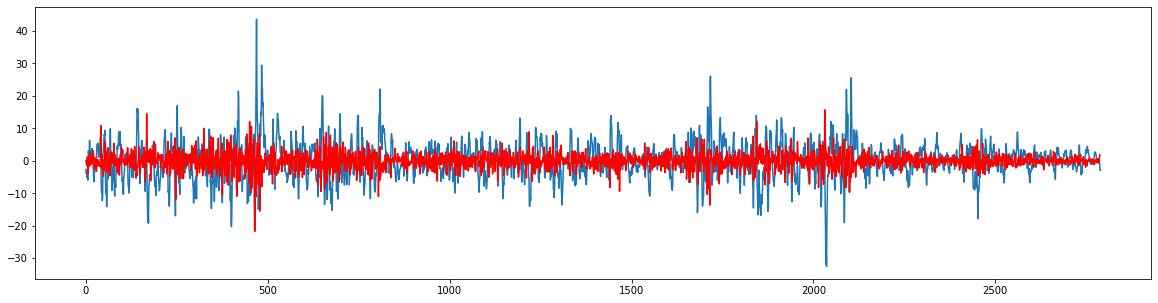

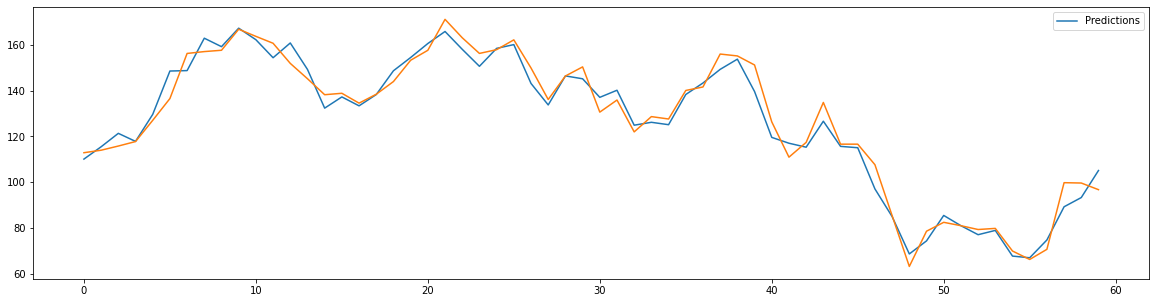

Cosine similarity :  0.9976828967895279
last days close =  [114.9  112.7  113.95 113.45 117.15 111.15 119.   113.65 112.2 ]
predicted prices for next 5 days are : 
116.24669514454546
111.54597133315154
113.62578664200934
112.67459539868743
114.99957904663971
NESTLEIND  ********************************


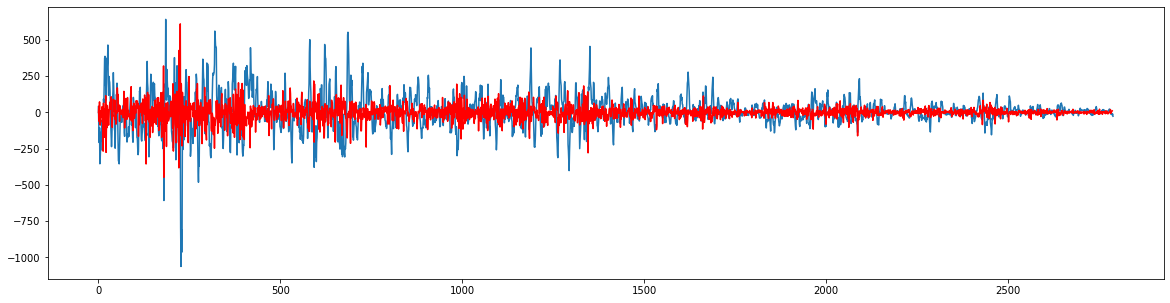

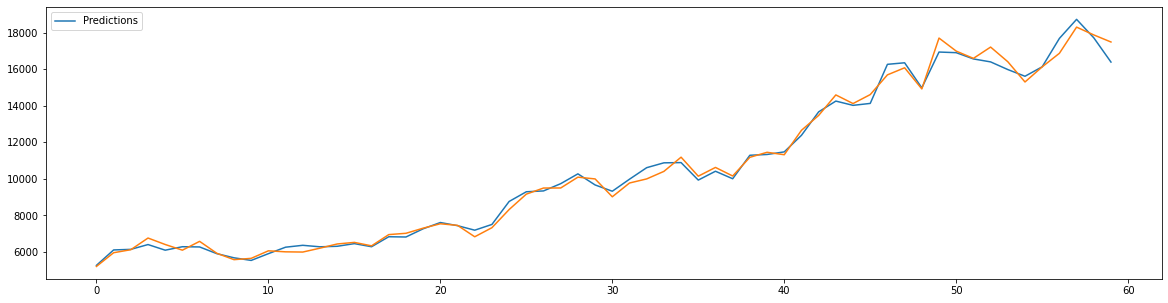

Cosine similarity :  0.9949838946973769
last days close =  [16774.4492 16649.4004 16694.8496 16571.9492 16288.2002 16097.7002
 16114.3496 16369.9502 16165.25  ]
predicted prices for next 5 days are : 
16283.348052102969
16562.33039756177
16687.28215667474
16649.89037337378
16775.404088299132
HDFC  ********************************


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



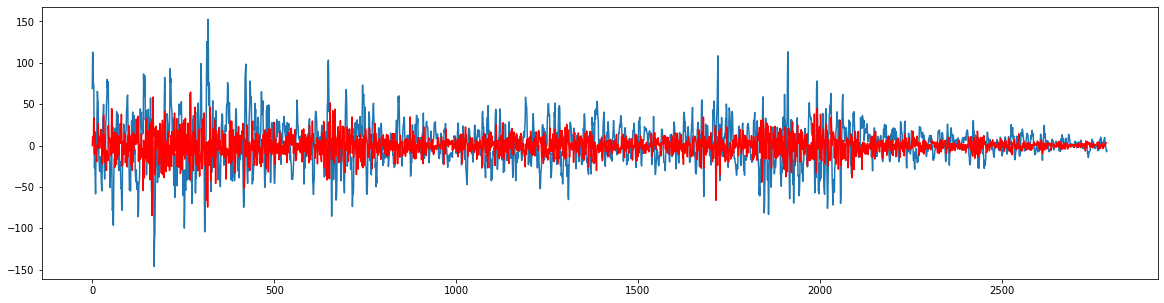

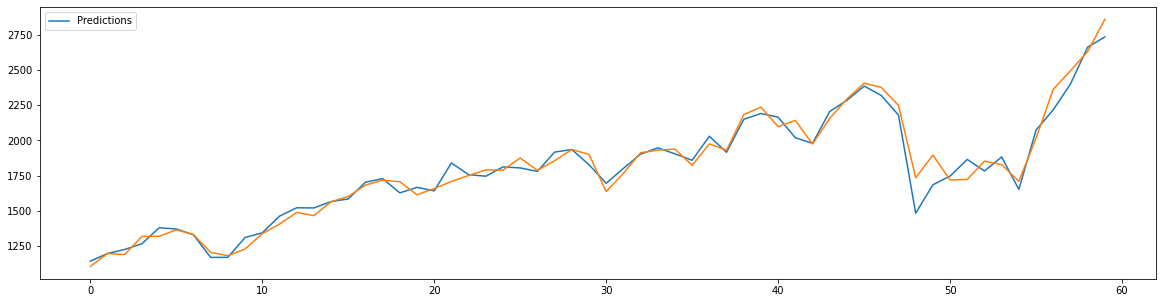

Cosine similarity :  0.9951359822402689
last days close =  [2543.25   2583.2    2652.8    2564.8999 2607.3    2539.05   2684.
 2713.75   2625.8999]
predicted prices for next 5 days are : 
2605.729388447222
2562.0035398763207
2652.0238668971574
2583.5514587986722
2543.273452406364


In [8]:
#Auto Regressive Integrated Moving Average (ARIMA) evaluation for ONGC forecasting

from collections import deque
from scipy import spatial
for stock in ["ONGC","NESTLEIND","HDFC"]:
  print(stock , " ********************************")
  train_data = db[stock][int(len(db[stock]) * 0.3) :]
  test_data = db[stock][0:int(len(db[stock]) * 0.3)]

  test_y = test_data['adjusted_close'].values
  test_data_return = train_data['return'].values
  test_data_close = train_data['adjusted_close'].values


  model = ARIMA(test_data_close, order = (5,2,2))
  results_AR = model.fit()  

  plt.figure(figsize=(20,5))
  plt.plot(test_data_return)
  plt.plot( -1*results_AR.fittedvalues, color='red')
  plt.show()

  result = 1 - spatial.distance.cosine(-1*results_AR.fittedvalues[:2000], test_data_return[:2000])
  #print('Cosine similarity : ' , result)

  y_pred = results_AR.predict(start=len(test_data_close)-2,end = len(test_y)+len(test_data_close)-3)
  y_pred =  y_pred
  test_y = [x for x in test_y]
  tmp_test = test_y[:5]
  for i in range(5,len(test_y)):
      y_pred[i] = y_pred[i] + test_y[i-4]
  

  plt.figure(figsize=(20,5))
  plt.plot(y_pred[::-20], label='Predictions')
  #plt.plot(test_y.flatten()[2:], label='actual')
  plt.plot(test_y[::-20])
  plt.legend()
  plt.show()


  result = 1 - spatial.distance.cosine(test_y, y_pred)
  print('Cosine similarity : ' , result)

  recent = db[stock]['adjusted_close'][:9].values
  all = db[stock]['adjusted_close'].values
  #print(recent)
  model_now = ARIMA(all, order = (5,2,2))
  model_fit_now = model_now.fit()  
  results_now = model_fit_now.predict(start=len(all)-2,end = 5+len(all)-3)
  print("last days close = " , recent)
  print("predicted prices for next 5 days are : ")
  #print(results_now,len(results_now))
  for i in range(5):
    print(results_now[i] + db[stock]['adjusted_close'][4-i])





In [9]:
#LSTM ON OHLC data


look_back = 20


series = db['ONGC'].iloc[::-1]
series = series.drop(columns=['timestamp','split_coefficient','return','log_return','dividend_amount','close'])

#print(series)
scaler = MinMaxScaler()
series = scaler.fit_transform(series)
print(series.shape)


train = series[:int(len(series)*0.7)]
test = series[int(len(series)*0.7):]

print("Len of train and test sets are  = ", len(train) , " " , len(test))




def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)
 
trainX , trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)

#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],5))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape,  trainY.shape)
'''
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

'''

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 5)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 5))





(3985, 5)
Len of train and test sets are  =  2789   1196
(2768, 20, 5) (2768, 5)


In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(trainX, trainY, validation_data=(testX,testY),epochs=5, batch_size=1, verbose=1)

Epoch 1/5
2768/2768 [==============================] - 46s 15ms/step - loss: 0.0147 - val_loss: 0.0029
Epoch 2/5
2768/2768 [==============================] - 40s 14ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 3/5
2768/2768 [==============================] - 40s 14ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/5
2768/2768 [==============================] - 40s 14ms/step - loss: 0.0028 - val_loss: 5.9306e-04
Epoch 5/5
2768/2768 [==============================] - 39s 14ms/step - loss: 0.0023 - val_loss: 5.7467e-04


(2768, 5)
(2768, 5)
0.0008710853849335685
0.0005746708882094565


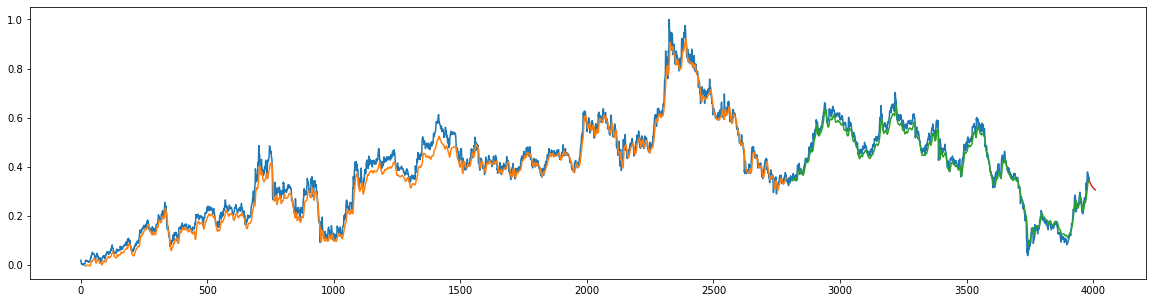

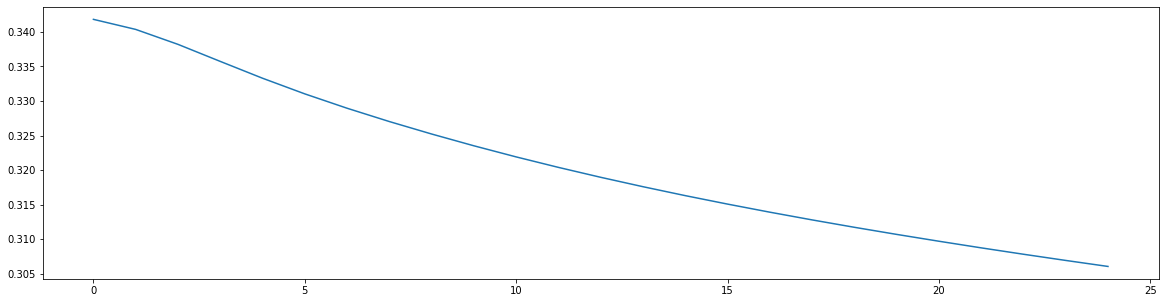

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print(trainPredict.shape)
print(trainY.shape)
print(mean_squared_error(trainPredict , trainY))
print(mean_squared_error(testPredict , testY))


bhawishya = np.array([])

curr = series[-look_back::]

kitna = 25
for i in range(kitna):
  trainCurr = np.array([curr])
  ans = model.predict(trainCurr)
  try:
    bhawishya = np.append(bhawishya,ans,axis =0) 
  except:
    bhawishya = ans
  curr = np.append(curr,ans,axis=0)
  curr = curr[1:]

test_Y = [np.NaN for i in range(2*look_back + len(trainY))]
train_Y = [np.NaN for i in range(look_back)]
future = [np.NaN for i in range(len(series))]


for i in range(len(trainPredict)):
  train_Y.append(trainPredict[i][3])
for i in range(len(testPredict)):
  test_Y.append(testPredict[i][3])
for i in range(kitna):
  future.append(bhawishya[i][3])


plt.figure(figsize=(20,5))
plt.plot(series[:,3])
plt.plot(train_Y,label="Training Output")
plt.plot(test_Y,label="Testing Output")
plt.plot(future,label = "Future Output")
plt.show()

plt.figure(figsize=(20,5))
plt.plot(future[len(series):])
plt.show()

LSTM ON RETURNS AND USING BATCHNORMALIZATION AND STANDARDIZATION



GRAPH OF RETURNS



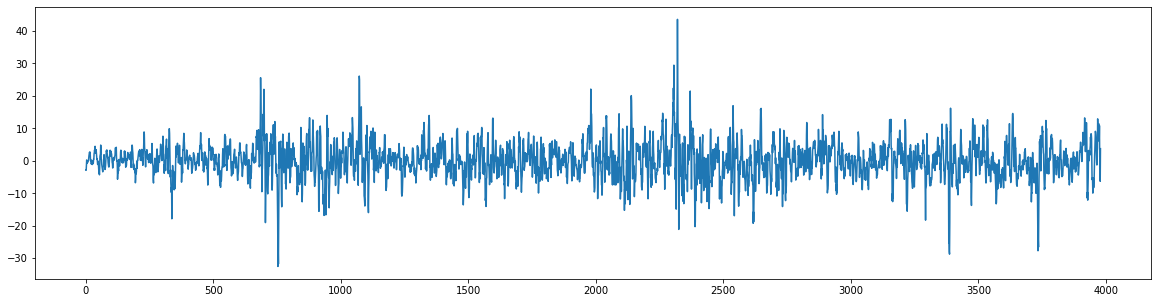



BELL SHAPED CURVE BELOW, THIS MEANS NORMAL DISTRIBUTION OF RETURNS



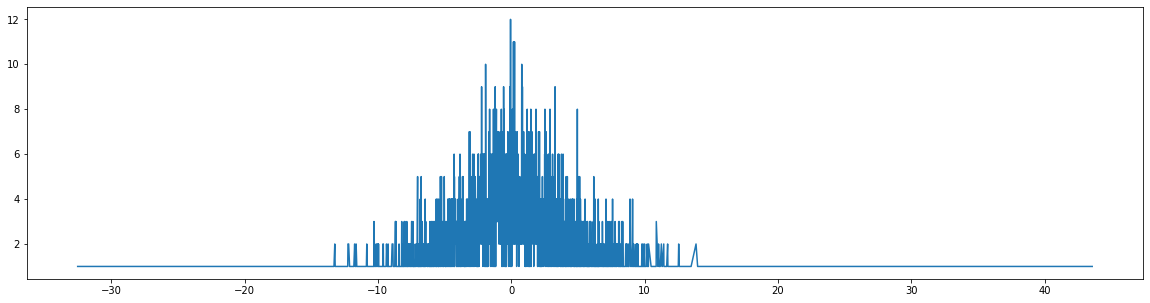



GRAPH OF STANDARDIZED RETURNS



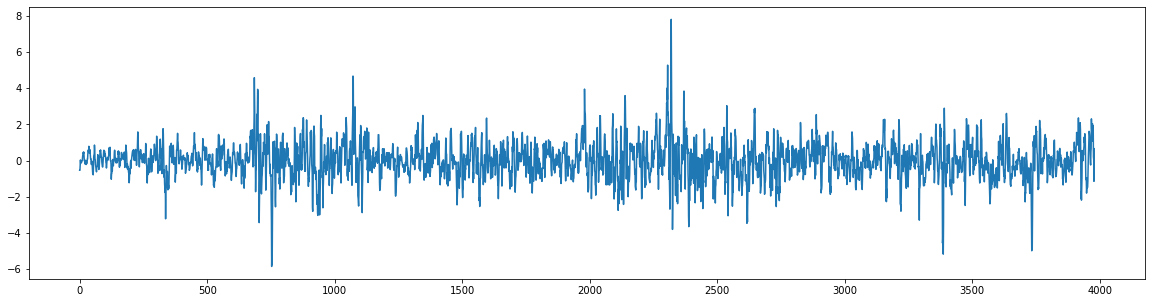



BELL SHAPED CURVE BELOW, THIS MEANS NORMAL DISTRIBUTION OF STANDARDIZED RETURNS



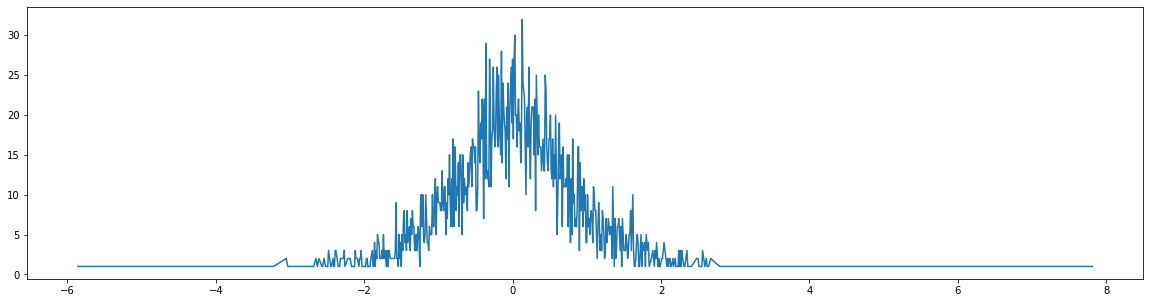


Shape of Training Data X and Y
(2765, 20, 1) (2765,)

Shape of Testing Data X and Y
(1173, 20, 1) (1173,)


In [12]:
#LSTM ON ONLY RETURNS:
look_back = 20

series = db['ONGC']['return'][5:].iloc[::-1]
series = series.values

print()
print()
print("GRAPH OF RETURNS")
print()
plt.figure(figsize=(20,5))
plt.plot(series)
plt.show()


freq = {}
for i in series:
  i = i.round(2)
  freq[i] = freq.get(i,0) + 1

X,Y = [],[]
for i in sorted(freq.keys()):
  X.append(i)
  Y.append(freq[i])
print()
print()
print("BELL SHAPED CURVE BELOW, THIS MEANS NORMAL DISTRIBUTION OF RETURNS")
print()
plt.figure(figsize = (20,5))
plt.plot(X,Y)
plt.show()

scaler = StandardScaler()
tmp = np.reshape(series,(-1,1))
scaler = scaler.fit(tmp)
standard = scaler.transform(tmp)

print()
print()
print("GRAPH OF STANDARDIZED RETURNS")
print()
plt.figure(figsize = (20,5))
plt.plot(standard)
plt.show()
freq = {}
for i in standard:
  i = i[0].round(2)
  freq[i] = freq.get(i,0) + 1

X,Y = [],[]
for i in sorted(freq.keys()):
  X.append(i)
  Y.append(freq[i])
print()
print()
print("BELL SHAPED CURVE BELOW, THIS MEANS NORMAL DISTRIBUTION OF STANDARDIZED RETURNS")
print()
plt.figure(figsize = (20,5))
plt.plot(X,Y)
plt.show()

def split(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
  
	return np.array(dataX).reshape((len(dataX),look_back,1)), np.array(dataY)
 


train,test = series[0:int(len(series)*0.7)] , series[int(len(series)*0.7) :]

train_x, train_y = split(train,look_back)
test_x , test_y = split(test,look_back)

print()
print("Shape of Training Data X and Y")
print(train_x.shape , train_y.shape)
print()
print("Shape of Testing Data X and Y")
print(test_x.shape , test_y.shape)

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))




In [13]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(train_x, train_y, validation_data=(test_x,test_y),epochs=2, batch_size=1, verbose=1)

Epoch 1/2
2765/2765 [==============================] - 45s 15ms/step - loss: 30.6658 - val_loss: 12.7523
Epoch 2/2
2765/2765 [==============================] - 40s 14ms/step - loss: 16.3958 - val_loss: 12.3529


[[-3.2355273 ]
 [-1.2340308 ]
 [-1.7697288 ]
 ...
 [ 5.7161503 ]
 [-0.08856907]
 [-2.921674  ]]
(1173, 1)
(1173,)
13.954609723853897
12.352932637932176


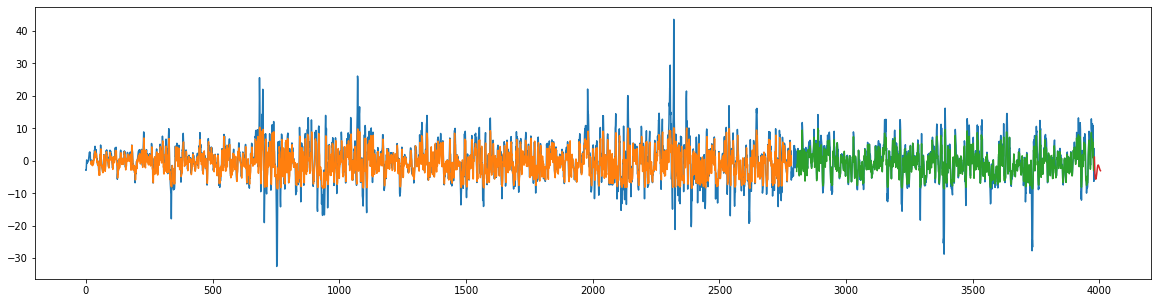

Future Graph : 


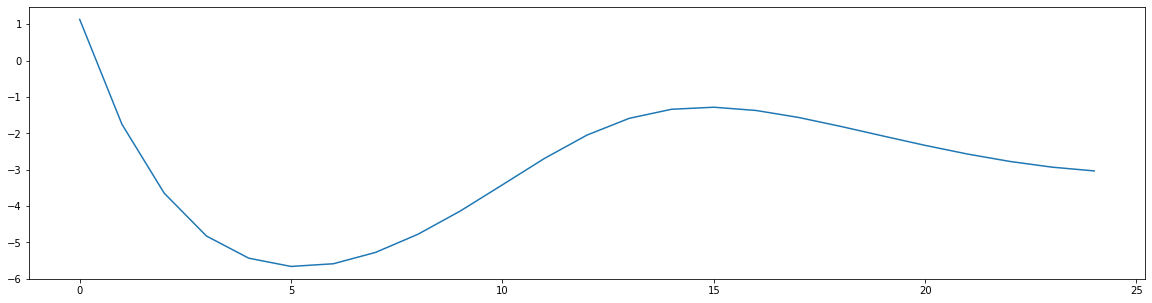

In [14]:
# make predictions
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)
print(testPredict)
print(testPredict.shape)
print(test_y.shape)
print(mean_squared_error(trainPredict , train_y))
print(mean_squared_error(testPredict , test_y))


bhawishya = np.array([])

curr = [[i] for i in series[-look_back:]]

kitna = 25
for i in range(kitna):
  trainCurr = np.array([curr])
  ans = model.predict(trainCurr)
  try:
    bhawishya = np.append(bhawishya,ans,axis =0) 
  except:
    bhawishya = ans
  curr = np.append(curr,ans,axis=0)
  curr = curr[1:]

test_Y = [np.NaN for i in range(2*look_back + len(train_y))]
train_Y = [np.NaN for i in range(look_back)]
future = [np.NaN for i in range(len(series))]


for i in range(len(trainPredict)):
  train_Y.append(trainPredict[i][0])
for i in range(len(testPredict)):
  test_Y.append(testPredict[i][0])
for i in range(kitna):
  future.append(bhawishya[i][0])


plt.figure(figsize=(20,5))
plt.plot(series)
plt.plot(train_Y,label="Training Output")
plt.plot(test_Y,label="Testing Output")
plt.plot(future,label = "Future Output")
plt.show()

print("Future Graph : ")
plt.figure(figsize=(20,5))
plt.plot(future[len(series):])
plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


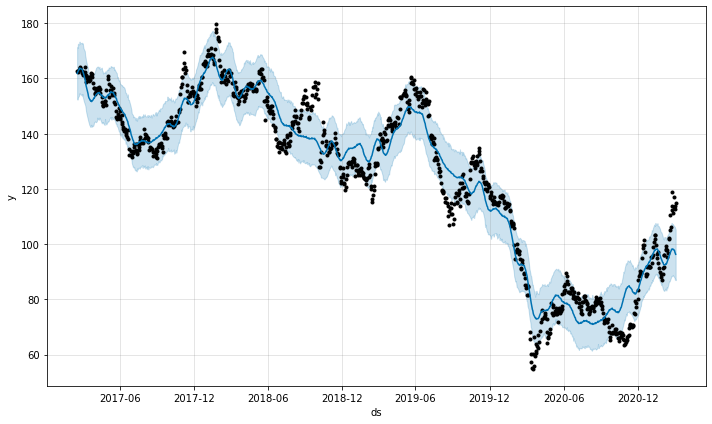

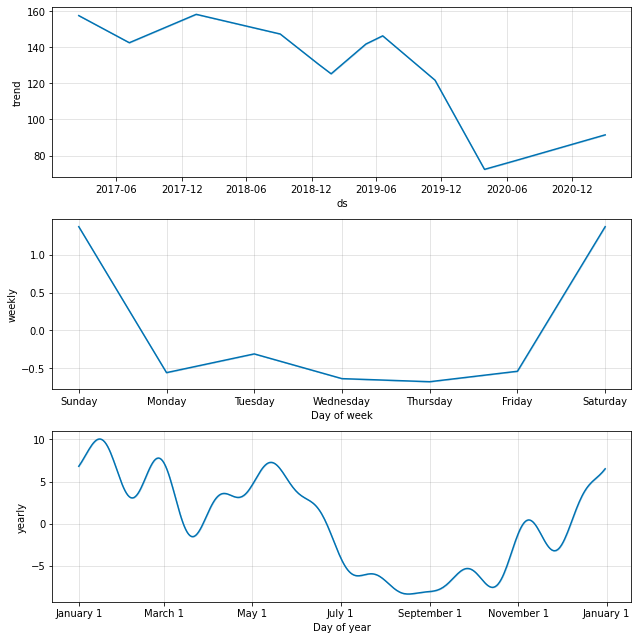

In [15]:
#Prophet by FaceBook
#!pip install fbprophet

call_back = 1000
prophet_results = {}

details = db['ONGC'][:call_back].filter(['timestamp','adjusted_close'])

details.columns = ['ds','y']            #ds and y are fixed names as per prophet documentation
details['ds'] = pd.to_datetime(details['ds'])

from fbprophet import Prophet
model = Prophet()

model.fit(details)

future = model.make_future_dataframe(periods=0)

prediction = model.predict(future)
model.plot(prediction)
plt.show()
model.plot_components(prediction)

#print(prediction)
workspace = prediction['trend'][-call_back:]
#print(workspace)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.



HCLTECH *************************



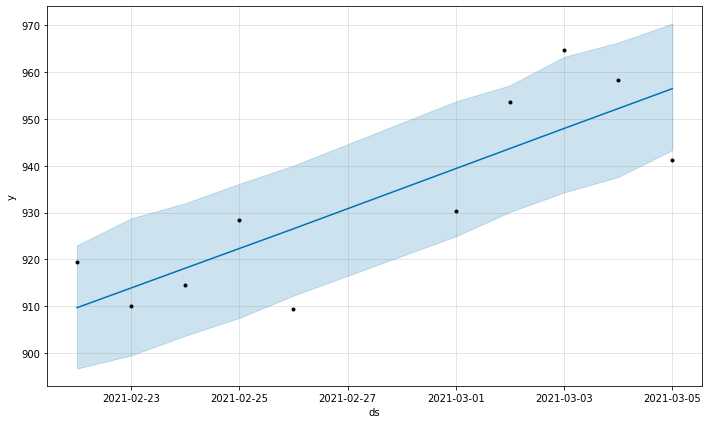

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [909.6745942977828, 913.891437144823, 918.1082808662035, 922.3251270370749, 926.5422636112867, 939.406098095783, 943.6940410183588, 947.9819748944732, 952.2355674073491, 956.489159920225]
[0, 909.67, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2.11, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 913.89, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2.11, 0, 0.0, 0, 0, 0, 0, 0, 0]
[4, 918.11, 0, 0.0, 0, -3e-05, 0, 0, 0, 0, 0]
[0, 0, 2.11, 0, -0.00021, 0, 0.00226, 0, 0, 0, 0]
[6, 922.33, 0, -0.00125, 0, 0.02261, 0, -0.00094, 0, 0, 0]
[0, 0, 2.105, 0, 0.18063, 0, -0.00901, 0, 0.0002, 0, 0]
[8, 926.54, 0, 1.0825, 0, -0.0675, 0, 0.00187, 0, -3e-05, 0]
[0, 0, 6.435, 0, -0.35938, 0, 0.01348, 0, -0.00027, 0, 0.0]
[10, 939.41, 0, -1.07375, 0, 0.06732, 0, -0.00187, 0, 3e-05, 0]
[0, 0, 2.14, 0, 0.17917, 0, -0.00898, 0, 0.0002, 0, 0]
[12, 943.69, 0, 0.00125, 0, -0.0225, 0, 0.00094, 0, 0, 0]
[0, 0, 2.145, 0, -0.00083, 0, 0.00227, 0, 0, 0, 0]
[14, 947.98, 0, -0.00375, 0, 0.00016, 0, 0, 0, 0, 0]
[0, 0, 

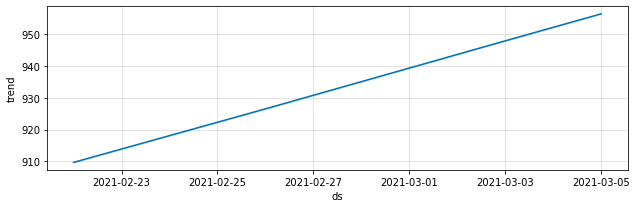

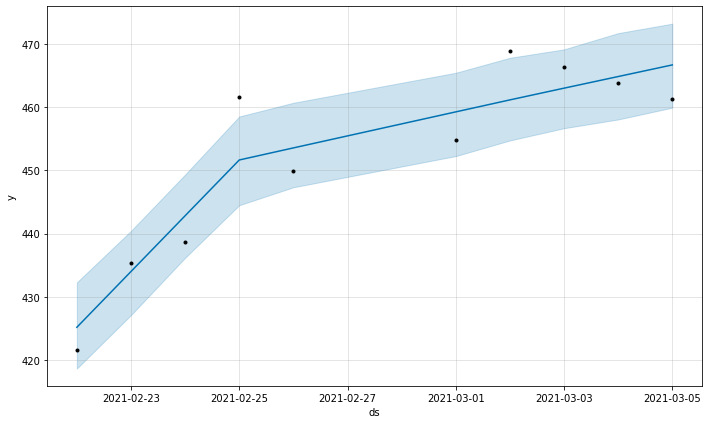

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [425.15659810161503, 433.9905701959313, 442.8245423509782, 451.6585033505458, 453.57282067081394, 459.28023129684885, 461.1786419570235, 463.0363911412116, 464.8778677971512, 466.7193444530909]
[0, 425.16, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 4.415, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 433.99, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 4.415, 0, 0.00021, 0, 0, 0, 0, 0, 0]
[4, 442.82, 0, 0.00125, 0, -0.0181, 0, 0, 0, 0, 0]
[0, 0, 4.42, 0, -0.14458, 0, 0.00641, 0, 0, 0, 0]
[6, 451.66, 0, -0.86625, 0, 0.04602, 0, -0.00132, 0, 0, 0]
[0, 0, 0.955, 0, 0.22354, 0, -0.00938, 0, 0.0002, 0, 0]
[8, 453.57, 0, 0.475, 0, -0.04776, 0, 0.00143, 0, -2e-05, 0]
[0, 0, 2.855, 0, -0.15854, 0, 0.00774, 0, -0.00017, 0, 0.0]
[10, 459.28, 0, -0.47625, 0, 0.02963, 0, -0.00097, 0, 2e-05, 0]
[0, 0, 0.95, 0, 0.07854, 0, -0.00394, 0, 0.0001, 0, 0]
[12, 461.18, 0, -0.005, 0, -0.00976, 0, 0.00041, 0, 0, 0]
[0, 0, 0.93, 0, 0.00042, 0, 0.00098, 0, 0, 0, 0]
[14, 463.04, 0, -0.0025, 0, 0.0, 0, 0, 0, 0, 

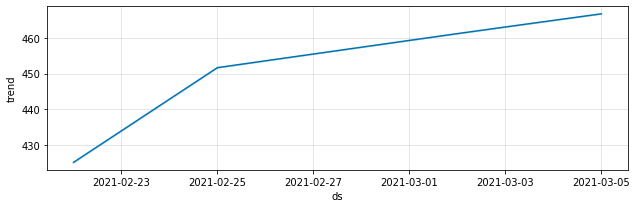

In [41]:
#Prophet by FaceBook
#!pip install fbprophet
'''
call_back = 10
prophet_results = {}
map_prophet = {}
for stock in ['HCLTECH', 'BPCL']:
    print()
    print(stock , "*************************")
    print()

    details = db[stock][:call_back].filter(['timestamp','adjusted_close'])

    details.columns = ['ds','y']            #ds and y are fixed names as per prophet documentation
    details['ds'] = pd.to_datetime(details['ds'])

    model = Prophet()

    model.fit(details)

    future = model.make_future_dataframe(periods=0)

    prediction = model.predict(future)
    model.plot(prediction)
    plt.show()
    model.plot_components(prediction)

    #print(prediction)
    workspace = prediction['trend'][-call_back:]
    
    #print(workspace)

    #Newton Divided Difference:
    def show(l):
      for i in range(len(l)):
        print(l[i])

    X = []
    Y = [i for i in workspace]
    X = [i for i in range(0,len(workspace)*2 , 2)]
    print(X,Y)
    

    x = symbols('x')
    n = len(workspace) 
    table = [[0 for i in range(n+1)] for j in range(2*n-1)]

    count = 0
    for i in workspace:
      table[count][0] = count
      table[count][1] = round(i,2)
      count+=2

    
    #show(table)
    tmp = 2*(n-1)
    for i in range(n-1):
      col = i + 2
      a = 0
      b = 2*(i+1)
      row = i + 1
      while row < tmp:
        #print(row , col)
        table[row][col] = (table[row+1][col-1] - table[row-1][col-1]) / (table[b][0] - table[a][0])
        table[row][col] = round(table[row][col],5)
        a+=2
        b+=2
        row = row + 2
      tmp = row-2
    show(table)
    expr = 0
    count = 1
    row = 1
    col = 2

    for i in range(1,n):
      tmp = 1
      for j in range(i):
        
            tmp*= (x - j*2)
          
      expr+=tmp * table[row][col]
      row+=1
      col+=1

    print("Expression : {} ".format(expr))    # + f(0) is missing in this final equation cause we are anyways differentiating it in the next step and f'(constant) = 0 so skip it.
    expr_diff = expr.diff() 
    tmp = expr.replace(x,18)
    print(tmp)
    print("Derivative of expression with respect to x : {}".format(expr_diff)) 
    print(2*(n-2))
    ans = expr_diff.replace(x,2*(n-1))

    print("The derivative at terminating date = " , ans)
    map_prophet[stock] = ans
print(map_prophet)
'''

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.



ONGC *************************



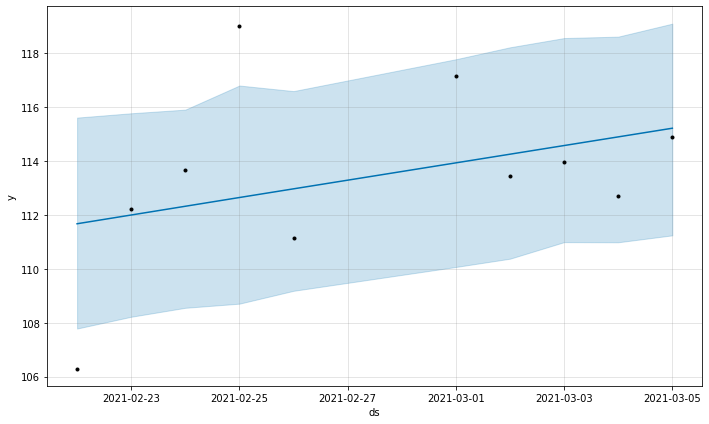

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [111.67056957510093, 111.99493746258734, 112.31930534954489, 112.64366532114472, 112.96553627385113, 113.9288959907208, 114.2500158754222, 114.57113576050764, 114.89225564478257, 115.21337552905747]
[0, 111.6706, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.3243, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 111.9949, 0, 0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.3244, 0, -0.0001, 0, 0, 0, 0, 0, 0]
[4, 112.3193, 0, 0.0, 0, -0.0025, 0, 0, 0, 0, 0]
[0, 0, 0.3244, 0, -0.0026, 0, 0.6493, 0, 0, 0, 0]
[6, 112.6437, 0, -0.0026, 0, 0.6468, 0, -3.2242, 0, 0, 0]
[0, 0, 0.3218, 0, 0.6442, 0, -2.5749, 0, 9.6534, 0, 0]
[8, 112.9655, 0, 0.6416, 0, -1.9281, 0, 6.4292, 0, -22.5053, 0]
[0, 0, 0.9634, 0, -1.2839, 0, 3.8543, 0, -12.8519, 0, 44.9902]
[10, 113.9289, 0, -0.6423, 0, 1.9262, 0, -6.4227, 0, 22.4849, 0]
[0, 0, 0.3211, 0, 0.6423, 0, -2.5684, 0, 9.633, 0, 0]
[12, 114.25, 0, 0.0, 0, -0.6422, 0, 3.2103, 0, 0, 0]
[0, 0, 0.3211, 0, 0.0001, 0, 0.6419, 0, 0, 0, 0]
[14, 114.5711, 0, 0.0001, 0, -0.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 3.09952325837743e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 3.09952325837743e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 3.09952325837743e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 3.09952325837743e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 3.09952325837743e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 3.09952325837743e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 3.09952325837743e-5*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 3.09952325837743e-5*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000139541790674603*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000139541790674603*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000139541790674603*x*(x/2 - 7)*

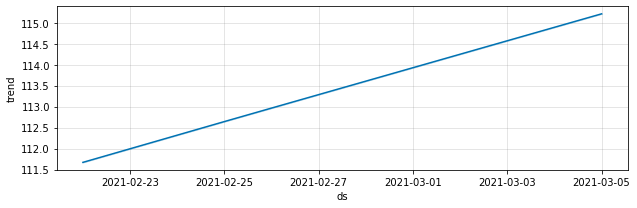

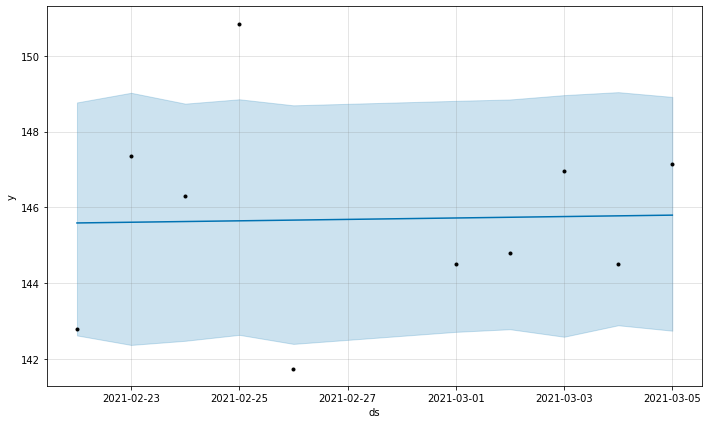

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [145.59159704319904, 145.61035163439982, 145.62910621901014, 145.64786079282936, 145.66660193628275, 145.72282536412263, 145.7415665007586, 145.76030763113815, 145.77904876933206, 145.79778990752598]
[0, 145.5916, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.0188, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 145.6104, 0, -0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.0187, 0, 0.0002, 0, 0, 0, 0, 0, 0]
[4, 145.6291, 0, 0.0001, 0, -0.0004, 0, 0, 0, 0, 0]
[0, 0, 0.0188, 0, -0.0002, 0, 0.0382, 0, 0, 0, 0]
[6, 145.6479, 0, -0.0001, 0, 0.0378, 0, -0.1885, 0, 0, 0]
[0, 0, 0.0187, 0, 0.0376, 0, -0.1503, 0, 0.5635, 0, 0]
[8, 145.6666, 0, 0.0375, 0, -0.1125, 0, 0.375, 0, -1.3126, 0]
[0, 0, 0.0562, 0, -0.0749, 0, 0.2247, 0, -0.7491, 0, 2.6224]
[10, 145.7228, 0, -0.0374, 0, 0.1122, 0, -0.3741, 0, 1.3098, 0]
[0, 0, 0.0188, 0, 0.0373, 0, -0.1494, 0, 0.5607, 0, 0]
[12, 145.7416, 0, -0.0001, 0, -0.0372, 0, 0.1866, 0, 0, 0]
[0, 0, 0.0187, 0, 0.0001, 0, 0.0372, 0, 0, 0, 0]
[14, 145.7603, 0, 0.0, 0, 0.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 1.80665784832452e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 1.80665784832452e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 1.80665784832452e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 1.80665784832452e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 1.80665784832452e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 1.80665784832452e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 1.80665784832452e-6*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 1.80665784832452e-6*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 8.13864087301587e-6*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 8.13864087301587e-6*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 8.13864087301587e-6*x*(x/2 - 7)*(x/

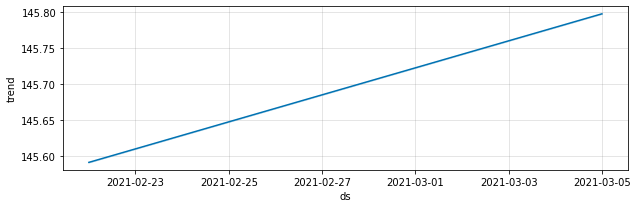

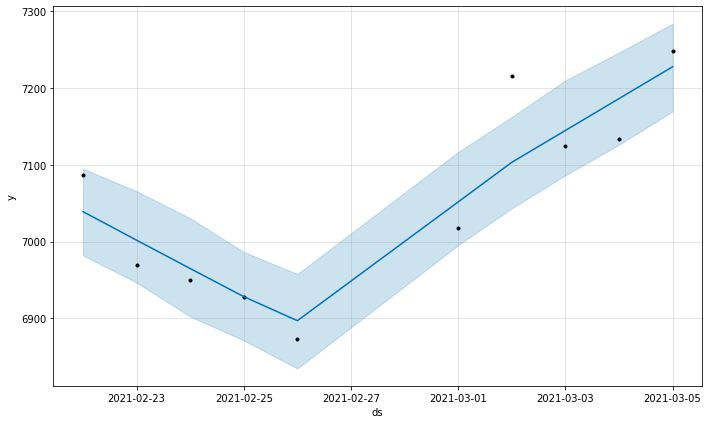

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [7038.973566938466, 7001.7888982208115, 6964.870917558956, 6928.222679757885, 6896.88244074374, 7051.594082425393, 7103.164584036194, 7144.664304081904, 7186.164014747703, 7227.6637254135]
[0, 7038.9736, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -37.1847, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 7001.7889, 0, 0.2667, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -36.918, 0, 0.0031, 0, 0, 0, 0, 0, 0]
[4, 6964.8709, 0, 0.2698, 0, 5.035, 0, 0, 0, 0, 0]
[0, 0, -36.6482, 0, 5.0381, 0, 170.671, 0, 0, 0, 0]
[6, 6928.2227, 0, 5.3079, 0, 175.706, 0, -816.3143, 0, 0, 0]
[0, 0, -31.3403, 0, 180.7441, 0, -645.6433, 0, 2314.1585, 0, 0]
[8, 6896.8824, 0, 186.052, 0, -469.9373, 0, 1497.8442, 0, -5129.4668, 0]
[0, 0, 154.7117, 0, -289.1932, 0, 852.2009, 0, -2815.3083, 0, 9800.4312]
[10, 7051.5941, 0, -103.1412, 0, 382.2636, 0, -1317.4641, 0, 4670.9644, 0]
[0, 0, 51.5705, 0, 93.0704, 0, -465.2632, 0, 1855.6561, 0, 0]
[12, 7103.1646, 0, -10.0708, 0, -82.9996, 0, 538.192, 0, 0, 0]
[0, 0, 41.4997, 0, 10.0708

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.00675184027777778*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.00675184027777778*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.00675184027777778*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.00675184027777778*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00675184027777778*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00675184027777778*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00675184027777778*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00675184027777778*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.0318047296626984*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.0318047296626984*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.0318047296626984*x*(x/2 - 7)*(x/2 -

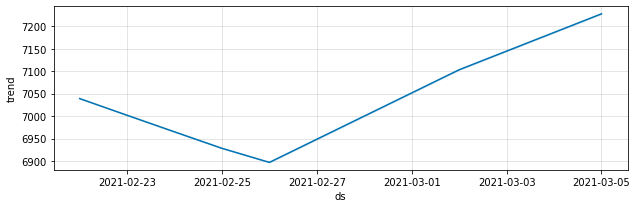

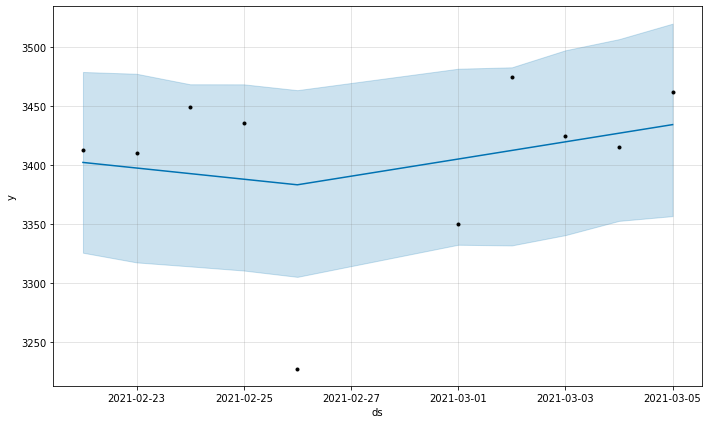

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [3402.277375842878, 3397.5334853514937, 3392.7896949371, 3388.045974038187, 3383.3027968909564, 3405.149749045868, 3412.453145844788, 3419.756461146113, 3427.0600833395783, 3434.3637055330437]
[0, 3402.2774, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -4.7439, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 3397.5335, 0, 0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -4.7438, 0, 0.0, 0, 0, 0, 0, 0, 0]
[4, 3392.7897, 0, 0.0001, 0, 0.0004, 0, 0, 0, 0, 0]
[0, 0, -4.7437, 0, 0.0004, 0, 26.5888, 0, 0, 0, 0]
[6, 3388.046, 0, 0.0005, 0, 26.5892, 0, -120.9012, 0, 0, 0]
[0, 0, -4.7432, 0, 26.5896, 0, -94.3124, 0, 338.6139, 0, 0]
[8, 3383.3028, 0, 26.5901, 0, -67.7232, 0, 217.7127, 0, -749.9473, 0]
[0, 0, 21.8469, 0, -41.1336, 0, 123.4003, 0, -411.3334, 0, 1439.6647]
[10, 3405.1497, 0, -14.5435, 0, 55.6771, 0, -193.6207, 0, 689.7174, 0]
[0, 0, 7.3034, 0, 14.5435, 0, -70.2204, 0, 278.384, 0, 0]
[12, 3412.4531, 0, 0.0, 0, -14.5433, 0, 84.7633, 0, 0, 0]
[0, 0, 7.3034, 0, 0.0002, 0, 14.5429, 0, 0, 0, 0]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.000991832492835097*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000991832492835097*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000991832492835097*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.000991832492835097*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000991832492835097*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000991832492835097*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000991832492835097*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000991832492835097*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.00464997085813492*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.00464997085813492*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.00464997085813492*x*(x/2 

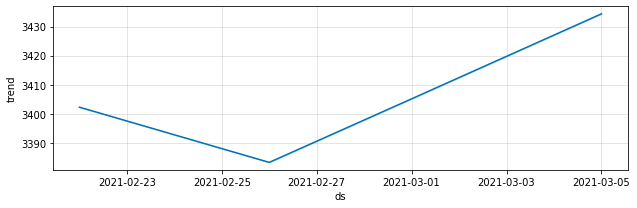

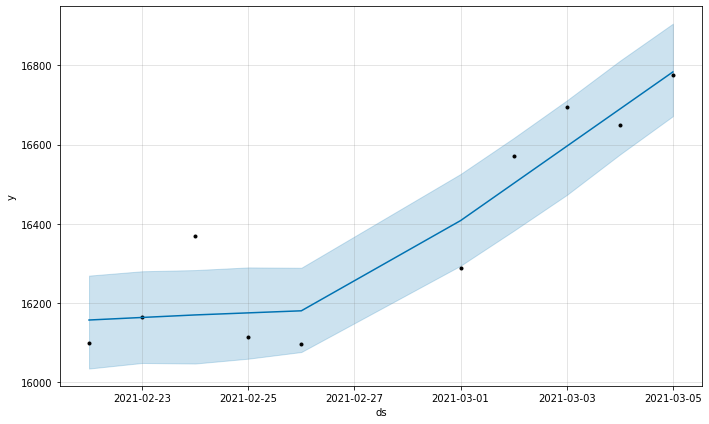

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [16157.158089707696, 16163.614370986175, 16169.980703330808, 16175.19464676562, 16180.408569729438, 16408.0712038507, 16501.880067147456, 16595.688945177586, 16689.497350369576, 16783.305755561567]
[0, 16157.1581, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 6.4563, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 16163.6144, 0, -0.09, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 6.3663, 0, -1.0624, 0, 0, 0, 0, 0, 0]
[4, 16169.9807, 0, -1.1524, 0, 2.2149, 0, 0, 0, 0, 0]
[0, 0, 5.2139, 0, 1.1525, 0, 219.0811, 0, 0, 0, 0]
[6, 16175.1946, 0, 0.0001, 0, 221.296, 0, -1019.1279, 0, 0, 0]
[0, 0, 5.214, 0, 222.4485, 0, -800.0468, 0, 2888.0814, 0, 0]
[8, 16180.4086, 0, 222.4486, 0, -578.7508, 0, 1868.9535, 0, -6449.9513, 0]
[0, 0, 227.6626, 0, -356.3023, 0, 1068.9067, 0, -3561.8699, 0, 12462.6015]
[10, 16408.0712, 0, -133.8537, 0, 490.1559, 0, -1692.9164, 0, 6012.6502, 0]
[0, 0, 93.8089, 0, 133.8536, 0, -624.0097, 0, 2450.7803, 0, 0]
[12, 16501.8801, 0, -0.0001, 0, -133.8538, 0, 757.8639, 0, 0, 0]
[0, 0, 93

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.00858589719742064*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.00858589719742064*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.00858589719742064*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.00858589719742064*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00858589719742064*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00858589719742064*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00858589719742064*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00858589719742064*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.0399922575644841*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.0399922575644841*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.0399922575644841*x*(x/2 - 7)*(x/2 -

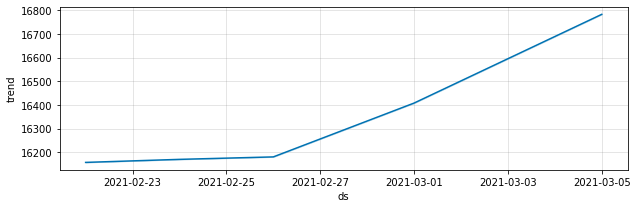

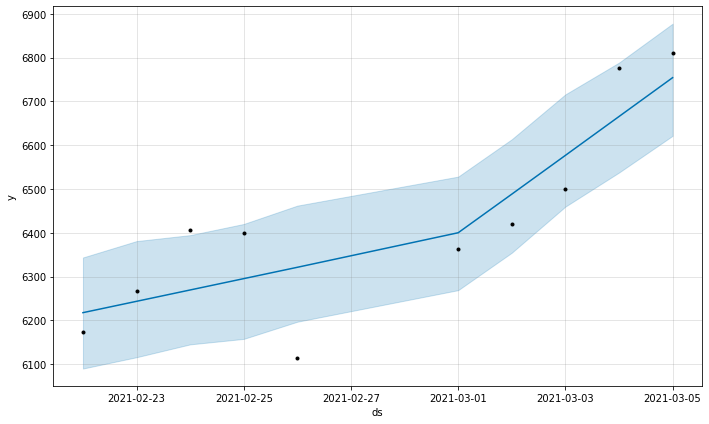

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [6217.891323216772, 6243.782784609679, 6269.674236921058, 6295.5656711693, 6321.457110623533, 6400.311693074409, 6488.402858637754, 6576.910741905699, 6665.611721793924, 6754.312701682149]
[0, 6217.8913, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 25.8915, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 6243.7828, 0, -0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 25.8914, 0, 0.0002, 0, 0, 0, 0, 0, 0]
[4, 6269.6742, 0, 0.0001, 0, -0.0004, 0, 0, 0, 0, 0]
[0, 0, 25.8915, 0, -0.0002, 0, 52.9639, 0, 0, 0, 0]
[6, 6295.5657, 0, -0.0001, 0, 52.9635, 0, -202.6173, 0, 0, 0]
[0, 0, 25.8914, 0, 52.9633, 0, -149.6534, 0, 483.8672, 0, 0]
[8, 6321.4571, 0, 52.9632, 0, -96.6899, 0, 281.2499, 0, -923.0236, 0]
[0, 0, 78.8546, 0, -43.7266, 0, 131.5965, 0, -439.1564, 0, 1537.8301]
[10, 6400.3117, 0, 9.2366, 0, 34.9066, 0, -157.9065, 0, 614.8065, 0]
[0, 0, 88.0912, 0, -8.82, 0, -26.31, 0, 175.6501, 0, 0]
[12, 6488.4029, 0, 0.4166, 0, 8.5966, 0, 17.7436, 0, 0, 0]
[0, 0, 88.5078, 0, -0.2234, 0, -8.5664, 0, 0, 0,

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.00105946187444885*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.00105946187444885*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.00105946187444885*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.00105946187444885*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00105946187444885*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00105946187444885*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00105946187444885*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00105946187444885*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.00572311259920635*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.00572311259920635*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.00572311259920635*x*(x/2 - 7)*(x/

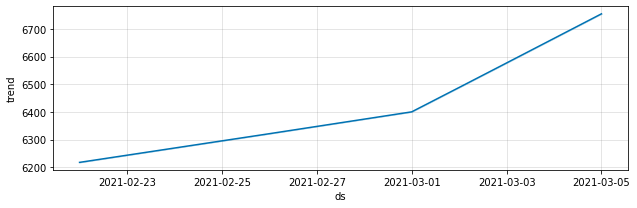

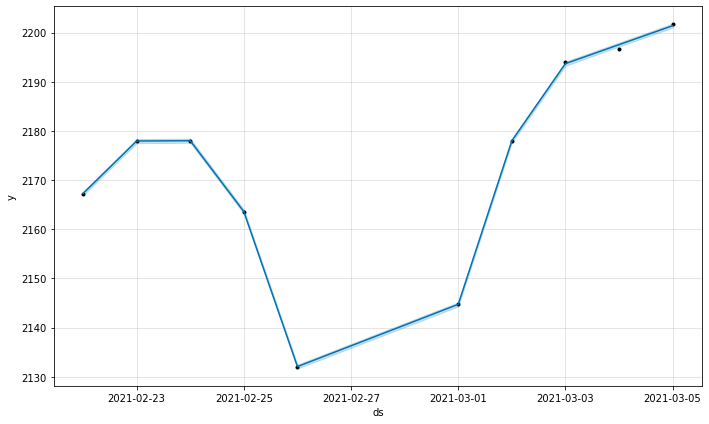

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [2167.260437555393, 2177.9395826065097, 2178.0000170035078, 2163.579099497104, 2132.070841690245, 2144.720853751207, 2177.979133447815, 2193.6781578094647, 2197.53334415522, 2201.3885305009753]
[0, 2167.2604, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10.6792, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2177.9396, 0, -10.6188, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.0604, 0, -3.8625, 0, 0, 0, 0, 0, 0]
[4, 2178.0, 0, -14.4813, 0, 1.2564, 0, 0, 0, 0, 0]
[0, 0, -14.4209, 0, -2.6061, 0, 62.5955, 0, 0, 0, 0]
[6, 2163.5791, 0, -17.0874, 0, 63.8519, 0, -211.2435, 0, 0, 0]
[0, 0, -31.5083, 0, 61.2458, 0, -148.648, 0, 430.0707, 0, 0]
[8, 2132.0708, 0, 44.1584, 0, -84.7961, 0, 218.8272, 0, -660.5779, 0]
[0, 0, 12.6501, 0, -23.5503, 0, 70.1792, 0, -230.5072, 0, 806.5126]
[10, 2144.7209, 0, 20.6081, 0, -14.6169, 0, -11.68, 0, 145.9347, 0]
[0, 0, 33.2582, 0, -38.1672, 0, 58.4992, 0, -84.5725, 0, 0]
[12, 2177.9791, 0, -17.5591, 0, 43.8823, 0, -96.2525, 0, 0, 0]
[0, 0, 15.6991, 0, 5.7151, 0, -37.753

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.000555633129409171*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000555633129409171*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000555633129409171*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.000555633129409171*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000555633129409171*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000555633129409171*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000555633129409171*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000555633129409171*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.0040958451140873*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.0040958451140873*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.0040958451140873*x*(x/2 - 7

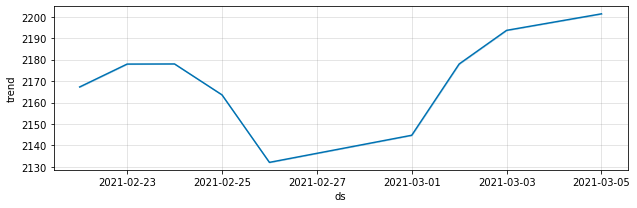

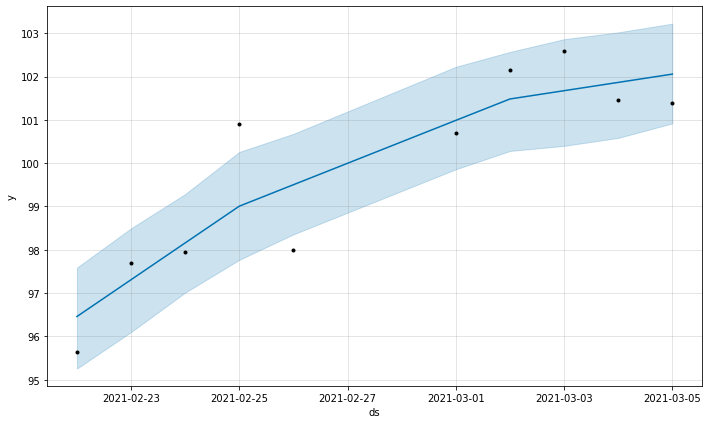

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [96.45954345547689, 97.30932924578616, 98.15911486576945, 99.00716849589914, 99.50232703130048, 100.98780224439973, 101.48151473904394, 101.67292995448538, 101.86429160485996, 102.05565325523452]
[0, 96.4595, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.8498, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 97.3093, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.8498, 0, -0.0017, 0, 0, 0, 0, 0, 0]
[4, 98.1591, 0, -0.0017, 0, -0.3496, 0, 0, 0, 0, 0]
[0, 0, 0.8481, 0, -0.3513, 0, 2.0443, 0, 0, 0, 0]
[6, 99.0072, 0, -0.353, 0, 1.6947, 0, -7.0646, 0, 0, 0]
[0, 0, 0.4951, 0, 1.3434, 0, -5.0203, 0, 18.0822, 0, 0]
[8, 99.5023, 0, 0.9904, 0, -3.3256, 0, 11.0176, 0, -38.156, 0]
[0, 0, 1.4855, 0, -1.9822, 0, 5.9973, 0, -20.0738, 0, 70.4298]
[10, 100.9878, 0, -0.9918, 0, 2.6717, 0, -9.0562, 0, 32.2738, 0]
[0, 0, 0.4937, 0, 0.6895, 0, -3.0589, 0, 12.2, 0, 0]
[12, 101.4815, 0, -0.3023, 0, -0.3872, 0, 3.1438, 0, 0, 0]
[0, 0, 0.1914, 0, 0.3023, 0, 0.0849, 0, 0, 0, 0]
[14, 101.6729, 0, 0.0, 0, -0.3023, 0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 4.8521412037037e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 4.8521412037037e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 4.8521412037037e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 4.8521412037037e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 4.8521412037037e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 4.8521412037037e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 4.8521412037037e-5*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 4.8521412037037e-5*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000236582341269841*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000236582341269841*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000236582341269841*x*(x/2 - 7)*(x/2 - 6

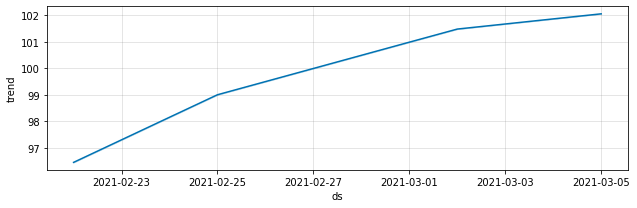

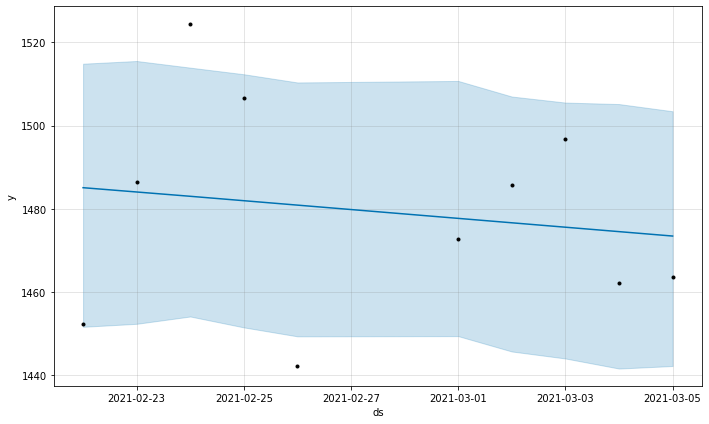

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [1485.0668601818268, 1484.0332853033744, 1482.9997098988129, 1481.93773325366, 1480.8757559875405, 1477.6898249423186, 1476.6278475983534, 1475.5658698984791, 1474.5038919397655, 1473.4419139810518]
[0, 1485.0669, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -1.0336, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1484.0333, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -1.0336, 0, -0.0284, 0, 0, 0, 0, 0, 0]
[4, 1482.9997, 0, -0.0284, 0, 0.0569, 0, 0, 0, 0, 0]
[0, 0, -1.062, 0, 0.0285, 0, -2.2096, 0, 0, 0, 0]
[6, 1481.9377, 0, 0.0001, 0, -2.1527, 0, 10.7346, 0, 0, 0]
[0, 0, -1.0619, 0, -2.1242, 0, 8.525, 0, -32.0039, 0, 0]
[8, 1480.8758, 0, -2.1241, 0, 6.3723, 0, -21.2693, 0, 74.5132, 0]
[0, 0, -3.186, 0, 4.2481, 0, -12.7443, 0, 42.5093, 0, -148.8816]
[10, 1477.6898, 0, 2.124, 0, -6.372, 0, 21.24, 0, -74.3684, 0]
[0, 0, -1.062, 0, -2.1239, 0, 8.4957, 0, -31.8591, 0, 0]
[12, 1476.6278, 0, 0.0001, 0, 2.1237, 0, -10.6191, 0, 0, 0]
[0, 0, -1.0619, 0, -0.0002, 0, -2.1234, 0, 0, 0, 0]
[14, 1475.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : -0.000102569444444444*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000102569444444444*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000102569444444444*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) - 0.000102569444444444*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000102569444444444*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000102569444444444*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000102569444444444*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000102569444444444*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000462011408730159*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000462011408730159*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000462011408730159*x*(

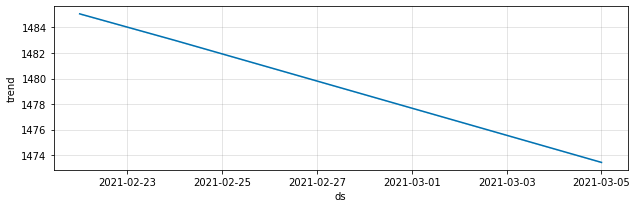

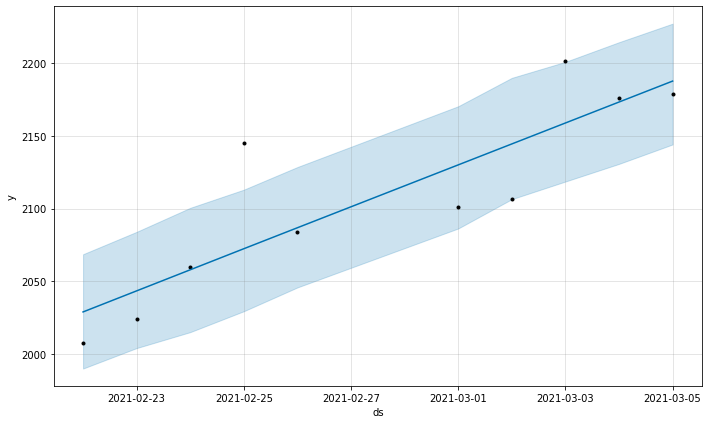

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [2028.9664858740314, 2043.4406205833272, 2057.9147520049205, 2072.3888405560624, 2086.8002140602107, 2129.9682990699093, 2144.357670329173, 2158.7470461791763, 2173.1364170404577, 2187.5257879017386]
[0, 2028.9665, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 14.4741, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2043.4406, 0, 0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 14.4742, 0, -0.0003, 0, 0, 0, 0, 0, 0]
[4, 2057.9148, 0, -0.0002, 0, -0.0621, 0, 0, 0, 0, 0]
[0, 0, 14.474, 0, -0.0624, 0, 28.9438, 0, 0, 0, 0]
[6, 2072.3888, 0, -0.0626, 0, 28.8817, 0, -144.1802, 0, 0, 0]
[0, 0, 14.4114, 0, 28.8193, 0, -115.2364, 0, 432.0853, 0, 0]
[8, 2086.8002, 0, 28.7567, 0, -86.3547, 0, 287.9051, 0, -1007.7515, 0]
[0, 0, 43.1681, 0, -57.5354, 0, 172.6687, 0, -575.6662, 0, 2015.0493]
[10, 2129.9683, 0, -28.7787, 0, 86.314, 0, -287.7611, 0, 1007.2978, 0]
[0, 0, 14.3894, 0, 28.7786, 0, -115.0924, 0, 431.6316, 0, 0]
[12, 2144.3577, 0, -0.0001, 0, -28.7784, 0, 143.8705, 0, 0, 0]
[0, 0, 14.3893, 0, 0.0002

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.00138823392030423*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.00138823392030423*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.00138823392030423*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.00138823392030423*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00138823392030423*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00138823392030423*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00138823392030423*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00138823392030423*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.00624845920138889*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.00624845920138889*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.00624845920138889*x*(x/2 - 7)*(x/

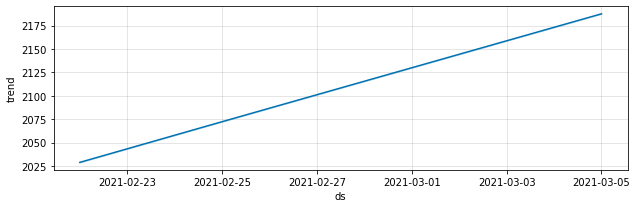

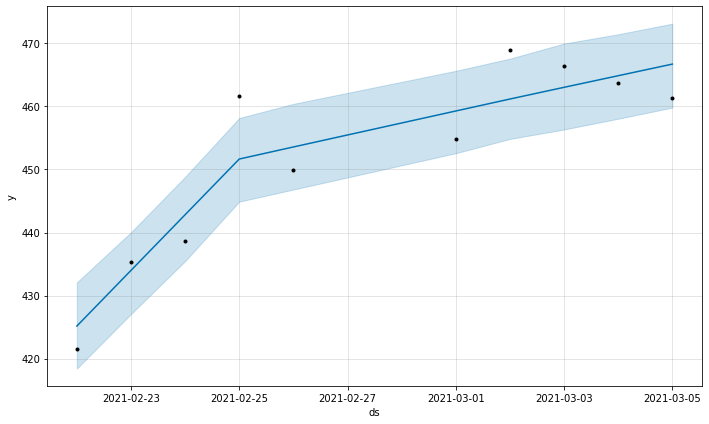

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [425.15659810161503, 433.9905701959313, 442.8245423509782, 451.6585033505458, 453.57282067081394, 459.28023129684885, 461.1786419570235, 463.0363911412116, 464.8778677971512, 466.7193444530909]
[0, 425.1566, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 8.834, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 433.9906, 0, -0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 8.8339, 0, 0.0002, 0, 0, 0, 0, 0, 0]
[4, 442.8245, 0, 0.0001, 0, -6.92, 0, 0, 0, 0, 0]
[0, 0, 8.834, 0, -6.9198, 0, 24.5526, 0, 0, 0, 0]
[6, 451.6585, 0, -6.9197, 0, 17.6326, 0, -60.5001, 0, 0, 0]
[0, 0, 1.9143, 0, 10.7128, 0, -35.9475, 0, 126.133, 0, 0]
[8, 453.5728, 0, 3.7931, 0, -18.3149, 0, 65.6329, 0, -236.5659, 0]
[0, 0, 5.7074, 0, -7.6021, 0, 29.6854, 0, -110.4329, 0, 410.6494]
[10, 459.2802, 0, -3.809, 0, 11.3705, 0, -44.8, 0, 174.0835, 0]
[0, 0, 1.8984, 0, 3.7684, 0, -15.1146, 0, 63.6506, 0, 0]
[12, 461.1786, 0, -0.0406, 0, -3.7441, 0, 18.8506, 0, 0, 0]
[0, 0, 1.8578, 0, 0.0243, 0, 3.736, 0, 0, 0, 0]
[14, 463.0364, 0, -0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


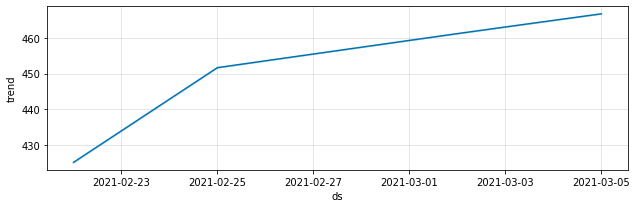

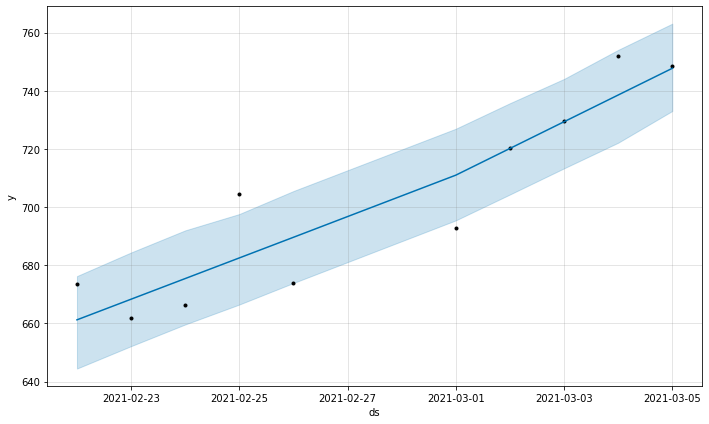

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [661.2289274823147, 668.3272161993393, 675.425504967849, 682.5237947533412, 689.6220845983148, 710.9899086394267, 720.1746814602806, 729.3626245475667, 738.5505676972102, 747.7385108468537]
[0, 661.2289, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 7.0983, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 668.3272, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 7.0983, 0, 0.0, 0, 0, 0, 0, 0, 0]
[4, 675.4255, 0, 0.0, 0, 0.0, 0, 0, 0, 0, 0]
[0, 0, 7.0983, 0, 0.0, 0, 14.2695, 0, 0, 0, 0]
[6, 682.5238, 0, 0.0, 0, 14.2695, 0, -69.261, 0, 0, 0]
[0, 0, 7.0983, 0, 14.2695, 0, -54.9915, 0, 203.6131, 0, 0]
[8, 689.6221, 0, 14.2695, 0, -40.722, 0, 134.3521, 0, -468.1535, 0]
[0, 0, 21.3678, 0, -26.4525, 0, 79.3606, 0, -264.5404, 0, 925.9018]
[10, 710.9899, 0, -12.183, 0, 38.6386, 0, -130.1883, 0, 457.7483, 0]
[0, 0, 9.1848, 0, 12.1861, 0, -50.8277, 0, 193.2079, 0, 0]
[12, 720.1747, 0, 0.0031, 0, -12.1891, 0, 63.0196, 0, 0, 0]
[0, 0, 9.1879, 0, -0.003, 0, 12.1919, 0, 0, 0, 0]
[14, 729.3626, 0, 0.0001, 0, 0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.000637884286816579*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000637884286816579*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000637884286816579*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.000637884286816579*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000637884286816579*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000637884286816579*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000637884286816579*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000637884286816579*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.00290273747519841*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.00290273747519841*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.00290273747519841*x*(x/2 

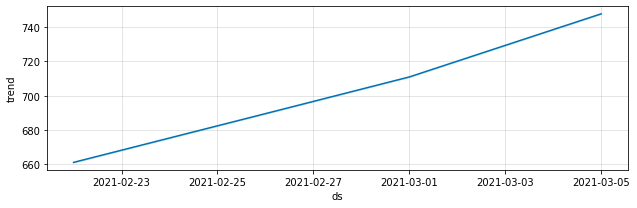

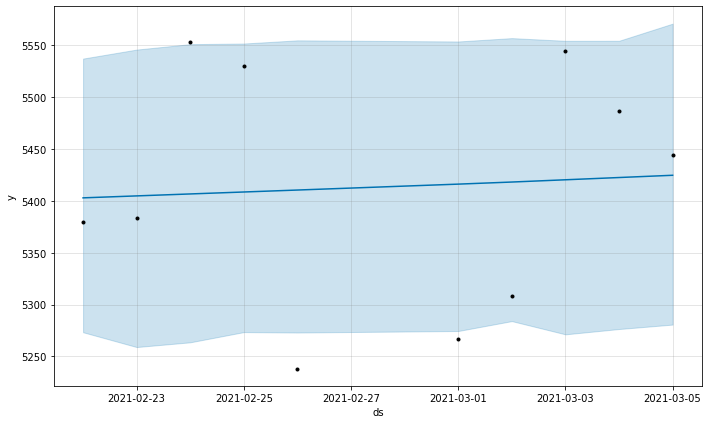

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [5402.922653535544, 5404.8068832259105, 5406.691112847551, 5408.575342420702, 5410.459571916351, 5416.160378584721, 5418.175091818987, 5420.3495618780735, 5422.524031857335, 5424.698501836597]
[0, 5402.9227, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1.8842, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 5404.8069, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1.8842, 0, 0.0, 0, 0, 0, 0, 0, 0]
[4, 5406.6911, 0, 0.0, 0, 0.0001, 0, 0, 0, 0, 0]
[0, 0, 1.8842, 0, 0.0001, 0, 3.8162, 0, 0, 0, 0]
[6, 5408.5753, 0, 0.0001, 0, 3.8163, 0, -18.9515, 0, 0, 0]
[0, 0, 1.8843, 0, 3.8164, 0, -15.1353, 0, 56.7543, 0, 0]
[8, 5410.4596, 0, 3.8165, 0, -11.319, 0, 37.8028, 0, -132.5789, 0]
[0, 0, 5.7008, 0, -7.5026, 0, 22.6675, 0, -75.8246, 0, 265.9455]
[10, 5416.1604, 0, -3.6861, 0, 11.3485, 0, -38.0218, 0, 133.3666, 0]
[0, 0, 2.0147, 0, 3.8459, 0, -15.3543, 0, 57.542, 0, 0]
[12, 5418.1751, 0, 0.1598, 0, -4.0058, 0, 19.5202, 0, 0, 0]
[0, 0, 2.1745, 0, -0.1599, 0, 4.1659, 0, 0, 0, 0]
[14, 5420.3496, 0, -0.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.000183218625992063*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000183218625992063*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000183218625992063*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.000183218625992063*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000183218625992063*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000183218625992063*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000183218625992063*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000183218625992063*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000822041790674603*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000822041790674603*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000822041790674603*x*(x

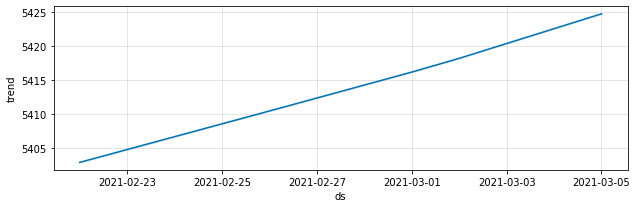

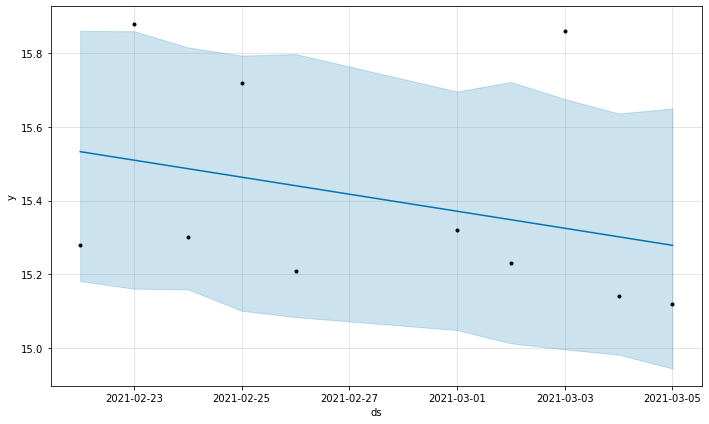

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [15.532687892246267, 15.509600149714057, 15.486512406598386, 15.463424663071885, 15.440336918885176, 15.371073685891545, 15.347985941546316, 15.324898196613368, 15.301722562741434, 15.278546928869496]
[0, 15.5327, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -0.0231, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 15.5096, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -0.0231, 0, 0.0, 0, 0, 0, 0, 0, 0]
[4, 15.4865, 0, 0.0, 0, 0.0, 0, 0, 0, 0, 0]
[0, 0, -0.0231, 0, 0.0, 0, -0.0461, 0, 0, 0, 0]
[6, 15.4634, 0, 0.0, 0, -0.0461, 0, 0.2305, 0, 0, 0]
[0, 0, -0.0231, 0, -0.0461, 0, 0.1844, 0, -0.6915, 0, 0]
[8, 15.4403, 0, -0.0461, 0, 0.1383, 0, -0.461, 0, 1.6134, 0]
[0, 0, -0.0692, 0, 0.0922, 0, -0.2766, 0, 0.9219, 0, -3.2263]
[10, 15.3711, 0, 0.0461, 0, -0.1383, 0, 0.4609, 0, -1.6129, 0]
[0, 0, -0.0231, 0, -0.0461, 0, 0.1843, 0, -0.691, 0, 0]
[12, 15.348, 0, 0.0, 0, 0.046, 0, -0.2301, 0, 0, 0]
[0, 0, -0.0231, 0, -0.0001, 0, -0.0458, 0, 0, 0, 0]
[14, 15.3249, 0, -0.0001, 0, 0.0002, 0, 0, 0, 0, 0]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : -2.22270447530864e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 2.22270447530864e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 2.22270447530864e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) - 2.22270447530864e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 2.22270447530864e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 2.22270447530864e-6*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 2.22270447530864e-6*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 2.22270447530864e-6*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 1.00037202380952e-5*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 1.00037202380952e-5*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 1.00037202380952e-5*x*(x/2 - 7)*(x

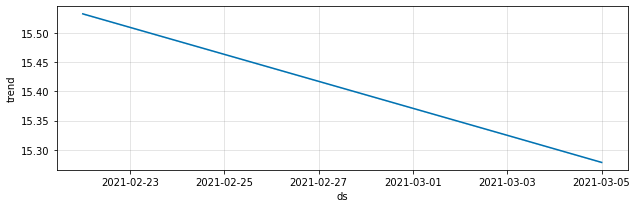

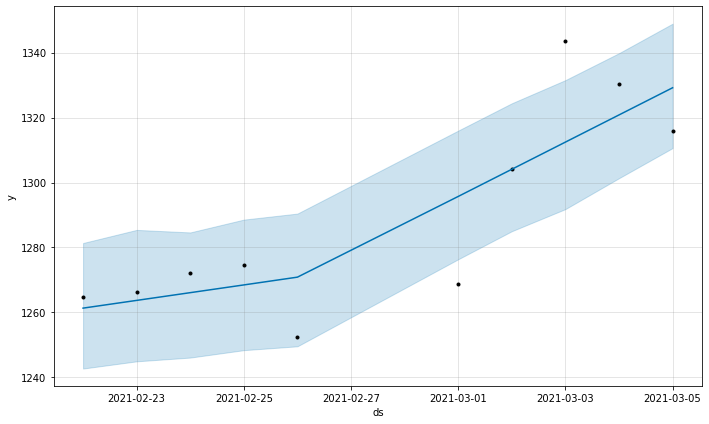

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [1261.328620973996, 1263.7097928947787, 1266.0909648217253, 1268.4721367955876, 1270.8679943217412, 1295.716876976399, 1304.0825506579392, 1312.4482243868115, 1320.8138974055523, 1329.179570424293]
[0, 1261.3286, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2.3812, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1263.7098, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2.3812, 0, -0.0001, 0, 0, 0, 0, 0, 0]
[4, 1266.091, 0, -0.0001, 0, 0.015, 0, 0, 0, 0, 0]
[0, 0, 2.3811, 0, 0.0149, 0, 22.4083, 0, 0, 0, 0]
[6, 1268.4721, 0, 0.0148, 0, 22.4233, 0, -106.206, 0, 0, 0]
[0, 0, 2.3959, 0, 22.4382, 0, -83.7977, 0, 306.7974, 0, 0]
[8, 1270.868, 0, 22.453, 0, -61.3744, 0, 200.5914, 0, -696.0847, 0]
[0, 0, 24.8489, 0, -38.9362, 0, 116.7937, 0, -389.2873, 0, 1362.4527]
[10, 1295.7169, 0, -16.4832, 0, 55.4193, 0, -188.6959, 0, 666.368, 0]
[0, 0, 8.3657, 0, 16.4831, 0, -71.9022, 0, 277.0807, 0, 0]
[12, 1304.0826, 0, -0.0001, 0, -16.4829, 0, 88.3848, 0, 0, 0]
[0, 0, 8.3656, 0, 0.0002, 0, 16.4826, 0, 0, 0, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.000938638599537037*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000938638599537037*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000938638599537037*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.000938638599537037*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000938638599537037*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000938638599537037*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000938638599537037*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000938638599537037*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.0043160013640873*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.0043160013640873*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.0043160013640873*x*(x/2 - 7

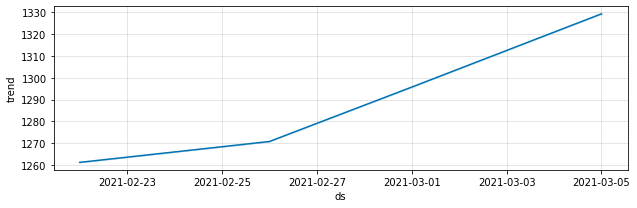

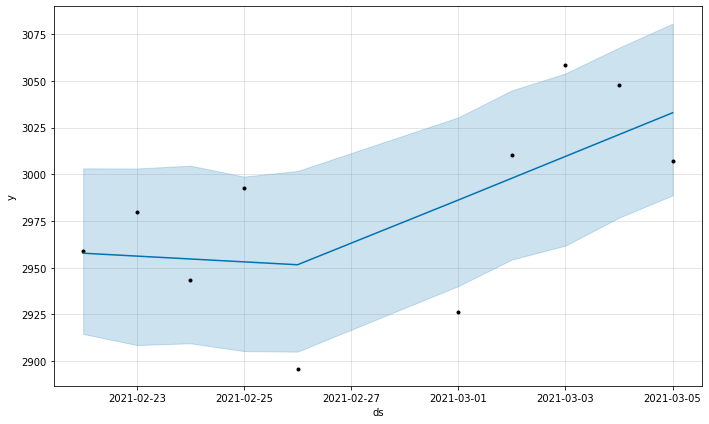

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [2957.7808352510274, 2956.2379013646755, 2954.6949660021937, 2953.1520319515307, 2951.6090992116997, 2986.2343050413197, 2997.9125882417534, 3009.5908717696657, 3021.269155973826, 3032.947440177987]
[0, 2957.7808, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -1.5429, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2956.2379, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -1.5429, 0, -0.0001, 0, 0, 0, 0, 0, 0]
[4, 2954.695, 0, -0.0001, 0, 0.0003, 0, 0, 0, 0, 0]
[0, 0, -1.543, 0, 0.0002, 0, 36.1675, 0, 0, 0, 0]
[6, 2953.152, 0, 0.0001, 0, 36.1678, 0, -167.6183, 0, 0, 0]
[0, 0, -1.5429, 0, 36.168, 0, -131.4508, 0, 476.414, 0, 0]
[8, 2951.6091, 0, 36.1681, 0, -95.283, 0, 308.7957, 0, -1067.5634, 0]
[0, 0, 34.6252, 0, -59.115, 0, 177.3449, 0, -591.1494, 0, 2069.0221]
[10, 2986.2343, 0, -22.9469, 0, 82.0619, 0, -282.3537, 0, 1001.4587, 0]
[0, 0, 11.6783, 0, 22.9469, 0, -105.0088, 0, 410.3093, 0, 0]
[12, 2997.9126, 0, 0.0, 0, -22.9469, 0, 127.9556, 0, 0, 0]
[0, 0, 11.6783, 0, 0.0, 0, 22.9468, 0, 0,

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.00142541756227954*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.00142541756227954*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.00142541756227954*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.00142541756227954*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00142541756227954*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00142541756227954*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00142541756227954*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00142541756227954*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.00661931671626984*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.00661931671626984*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.00661931671626984*x*(x/2 - 7)*(x/

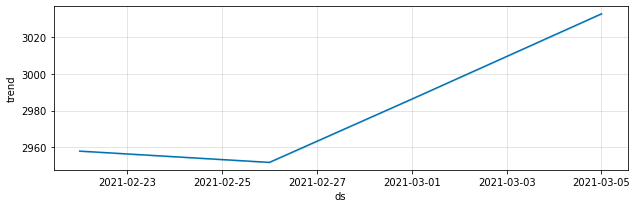

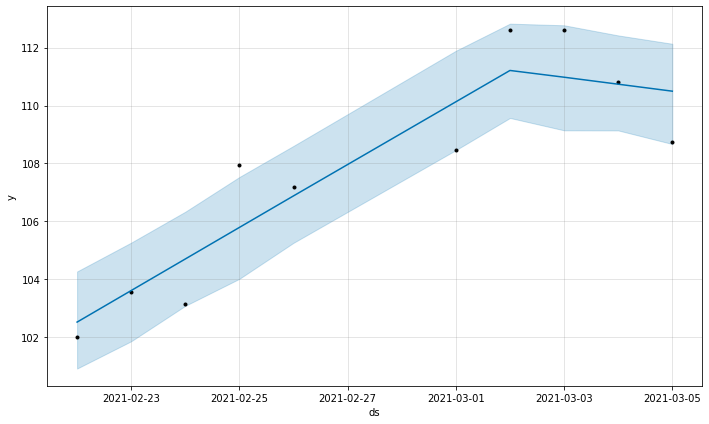

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [102.52003672183803, 103.61017801844883, 104.70031931055232, 105.79046060557377, 106.87953826088375, 110.1286635669888, 111.21085085324256, 110.97759973422988, 110.73645196587991, 110.49530419752993]
[0, 102.52, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1.0902, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 103.6102, 0, -0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1.0901, 0, 0.0002, 0, 0, 0, 0, 0, 0]
[4, 104.7003, 0, 0.0001, 0, -0.0015, 0, 0, 0, 0, 0]
[0, 0, 1.0902, 0, -0.0013, 0, 2.1642, 0, 0, 0, 0]
[6, 105.7905, 0, -0.0012, 0, 2.1627, 0, -10.8155, 0, 0, 0]
[0, 0, 1.089, 0, 2.1614, 0, -8.6513, 0, 31.1341, 0, 0]
[8, 106.8795, 0, 2.1602, 0, -6.4886, 0, 20.3186, 0, -67.8425, 0]
[0, 0, 3.2492, 0, -4.3272, 0, 11.6673, 0, -36.7084, 0, 123.907]
[10, 110.1287, 0, -2.167, 0, 5.1787, 0, -16.3898, 0, 56.0645, 0]
[0, 0, 1.0822, 0, 0.8515, 0, -4.7225, 0, 19.3561, 0, 0]
[12, 111.2109, 0, -1.3155, 0, 0.4562, 0, 2.9663, 0, 0, 0]
[0, 0, -0.2333, 0, 1.3077, 0, -1.7562, 0, 0, 0, 0]
[14, 110.9776, 0, -0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 8.53636188271605e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 8.53636188271605e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 8.53636188271605e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 8.53636188271605e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 8.53636188271605e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 8.53636188271605e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 8.53636188271605e-5*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 8.53636188271605e-5*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000420650421626984*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000420650421626984*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000420650421626984*x*(x/2 - 7)*

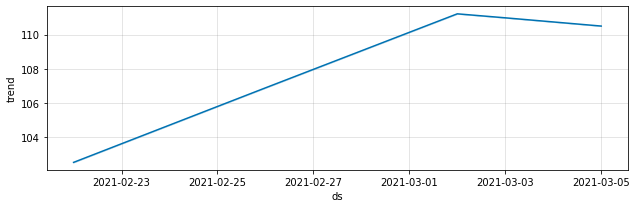

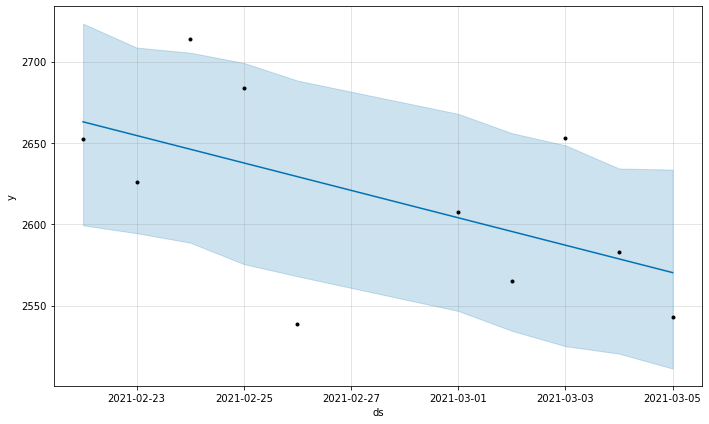

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [2662.979521505998, 2654.5567983029077, 2646.134087933617, 2637.7113488630653, 2629.2886094078517, 2604.0204099753805, 2595.597662695723, 2587.1749182342483, 2578.752191125689, 2570.32946401713]
[0, 2662.9795, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -8.4227, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2654.5568, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -8.4227, 0, -0.0001, 0, 0, 0, 0, 0, 0]
[4, 2646.1341, 0, -0.0001, 0, 0.0003, 0, 0, 0, 0, 0]
[0, 0, -8.4228, 0, 0.0002, 0, -16.8461, 0, 0, 0, 0]
[6, 2637.7113, 0, 0.0001, 0, -16.8458, 0, 84.2285, 0, 0, 0]
[0, 0, -8.4227, 0, -16.8456, 0, 67.3824, 0, -252.6841, 0, 0]
[8, 2629.2886, 0, -16.8455, 0, 50.5366, 0, -168.4556, 0, 589.5953, 0]
[0, 0, -25.2682, 0, 33.691, 0, -101.0732, 0, 336.9112, 0, -1179.1906]
[10, 2604.0204, 0, 16.8455, 0, -50.5366, 0, 168.4556, 0, -589.5953, 0]
[0, 0, -8.4227, 0, -16.8456, 0, 67.3824, 0, -252.6841, 0, 0]
[12, 2595.5977, 0, -0.0001, 0, 16.8458, 0, -84.2285, 0, 0, 0]
[0, 0, -8.4228, 0, 0.0002, 0, -16.846

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : -0.000812383294753086*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000812383294753086*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000812383294753086*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) - 0.000812383294753086*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000812383294753086*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000812383294753086*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000812383294753086*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000812383294753086*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.00365572482638889*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.00365572482638889*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.00365572482638889*x*(x/2

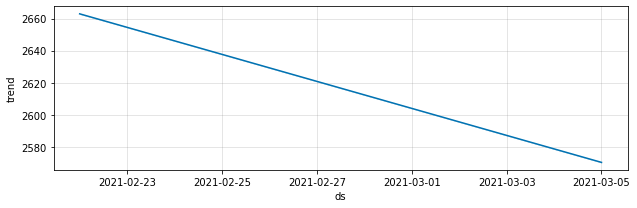

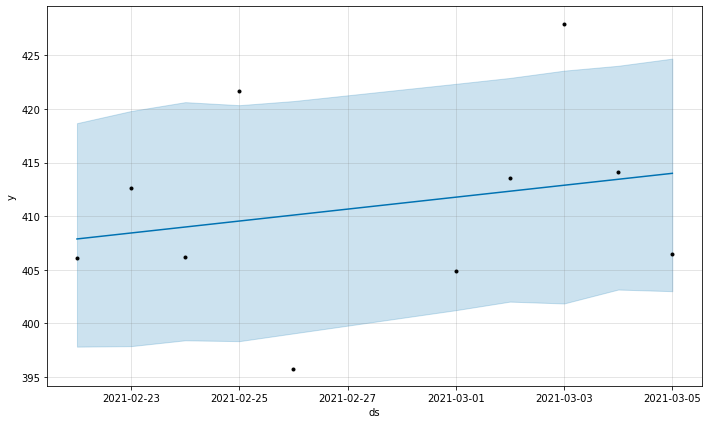

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [407.88077977451303, 408.4370338467396, 408.9932877973936, 409.5495417311178, 410.1057957583291, 411.77455764109783, 412.3308115778136, 412.88706549954384, 413.4424245245327, 413.99778354952156]
[0, 407.8808, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.5562, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 408.437, 0, 0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0.5563, 0, -0.0002, 0, 0, 0, 0, 0, 0]
[4, 408.9933, 0, -0.0001, 0, 0.0004, 0, 0, 0, 0, 0]
[0, 0, 0.5562, 0, 0.0002, 0, 1.1118, 0, 0, 0, 0]
[6, 409.5495, 0, 0.0001, 0, 1.1122, 0, -5.5615, 0, 0, 0]
[0, 0, 0.5563, 0, 1.1124, 0, -4.4497, 0, 16.6865, 0, 0]
[8, 410.1058, 0, 1.1125, 0, -3.3375, 0, 11.125, 0, -38.9384, 0]
[0, 0, 1.6688, 0, -2.2251, 0, 6.6753, 0, -22.2519, 0, 77.8848]
[10, 411.7746, 0, -1.1126, 0, 3.3378, 0, -11.1269, 0, 38.9464, 0]
[0, 0, 0.5562, 0, 1.1127, 0, -4.4516, 0, 16.6945, 0, 0]
[12, 412.3308, 0, 0.0001, 0, -1.1138, 0, 5.5676, 0, 0, 0]
[0, 0, 0.5563, 0, -0.0011, 0, 1.116, 0, 0, 0, 0]
[14, 412.8871, 0, -0.001, 0, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 5.36574074074074e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 5.36574074074074e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 5.36574074074074e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 5.36574074074074e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 5.36574074074074e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 5.36574074074074e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 5.36574074074074e-5*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 5.36574074074074e-5*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000241433531746032*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000241433531746032*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000241433531746032*x*(x/2 - 7)*

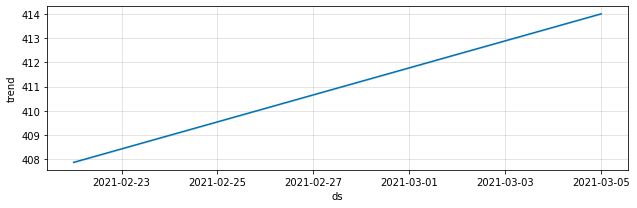

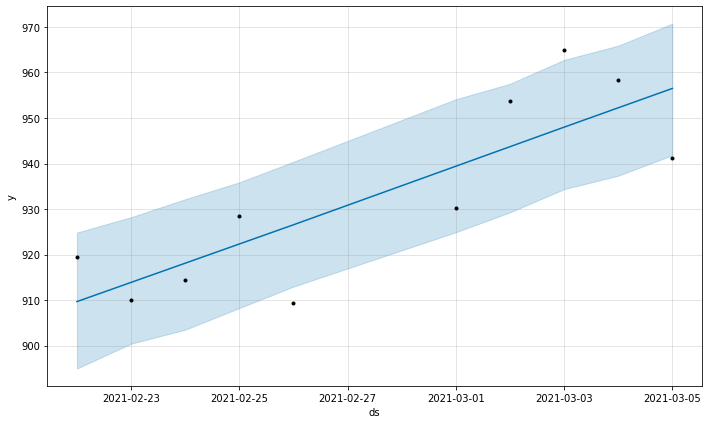

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [909.6745942977828, 913.891437144823, 918.1082808662035, 922.3251270370749, 926.5422636112867, 939.406098095783, 943.6940410183588, 947.9819748944732, 952.2355674073491, 956.489159920225]
[0, 909.6746, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 4.2168, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 913.8914, 0, 0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 4.2169, 0, -0.0002, 0, 0, 0, 0, 0, 0]
[4, 918.1083, 0, -0.0001, 0, 0.0007, 0, 0, 0, 0, 0]
[0, 0, 4.2168, 0, 0.0005, 0, 8.645, 0, 0, 0, 0]
[6, 922.3251, 0, 0.0004, 0, 8.6457, 0, -43.1594, 0, 0, 0]
[0, 0, 4.2172, 0, 8.6462, 0, -34.5144, 0, 129.341, 0, 0]
[8, 926.5423, 0, 8.6466, 0, -25.8687, 0, 86.1816, 0, -301.5988, 0]
[0, 0, 12.8638, 0, -17.2225, 0, 51.6672, 0, -172.2578, 0, 603.0212]
[10, 939.4061, 0, -8.5759, 0, 25.7985, 0, -86.0762, 0, 301.4224, 0]
[0, 0, 4.2879, 0, 8.576, 0, -34.409, 0, 129.1646, 0, 0]
[12, 943.694, 0, 0.0001, 0, -8.6105, 0, 43.0884, 0, 0, 0]
[0, 0, 4.288, 0, -0.0345, 0, 8.6794, 0, 0, 0, 0]
[14, 947.982, 0, -0.0344

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


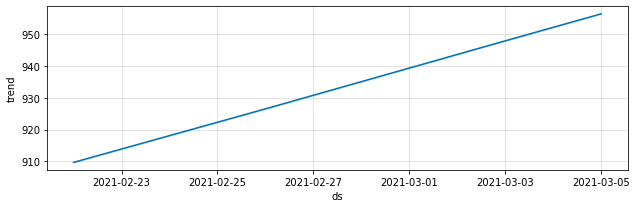

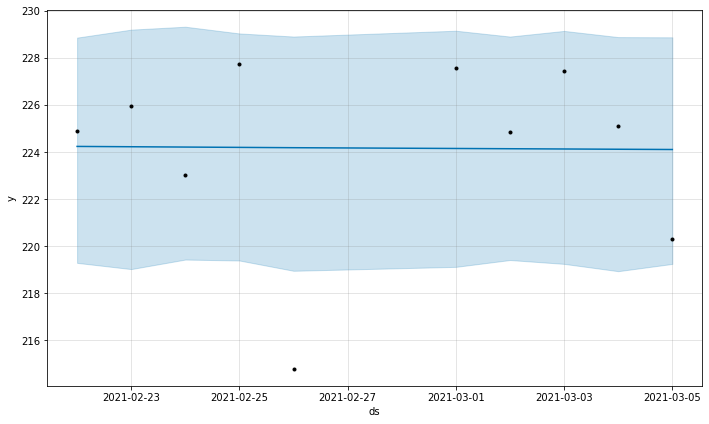

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [224.23268447292386, 224.2191518953634, 224.2056193282111, 224.19208677999194, 224.17855422958453, 224.14571849181783, 224.13477323389955, 224.1238165186493, 224.11285975254142, 224.10190298643352]
[0, 224.2327, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -0.0135, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 224.2192, 0, -0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -0.0136, 0, 0.0002, 0, 0, 0, 0, 0, 0]
[4, 224.2056, 0, 0.0001, 0, -0.0003, 0, 0, 0, 0, 0]
[0, 0, -0.0135, 0, -0.0001, 0, -0.019, 0, 0, 0, 0]
[6, 224.1921, 0, 0.0, 0, -0.0193, 0, 0.0991, 0, 0, 0]
[0, 0, -0.0135, 0, -0.0194, 0, 0.0801, 0, -0.3035, 0, 0]
[8, 224.1786, 0, -0.0194, 0, 0.0608, 0, -0.2044, 0, 0.718, 0]
[0, 0, -0.0329, 0, 0.0414, 0, -0.1243, 0, 0.4145, 0, -1.4511]
[10, 224.1457, 0, 0.022, 0, -0.0635, 0, 0.2101, 0, -0.7331, 0]
[0, 0, -0.0109, 0, -0.0221, 0, 0.0858, 0, -0.3186, 0, 0]
[12, 224.1348, 0, -0.0001, 0, 0.0223, 0, -0.1085, 0, 0, 0]
[0, 0, -0.011, 0, 0.0002, 0, -0.0227, 0, 0, 0, 0]
[14, 224.1238, 0, 0.0001, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : -9.99710648148148e-7*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 9.99710648148148e-7*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 9.99710648148148e-7*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) - 9.99710648148148e-7*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 9.99710648148148e-7*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 9.99710648148148e-7*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 9.99710648148148e-7*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 9.99710648148148e-7*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 4.45188492063492e-6*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 4.45188492063492e-6*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 4.45188492063492e-6*x*(x/2 - 7)*(x

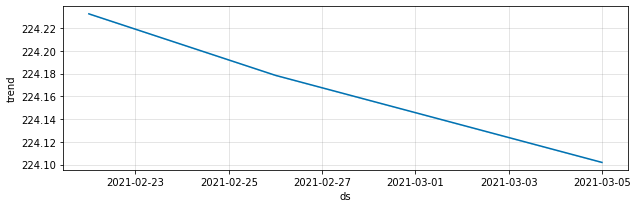

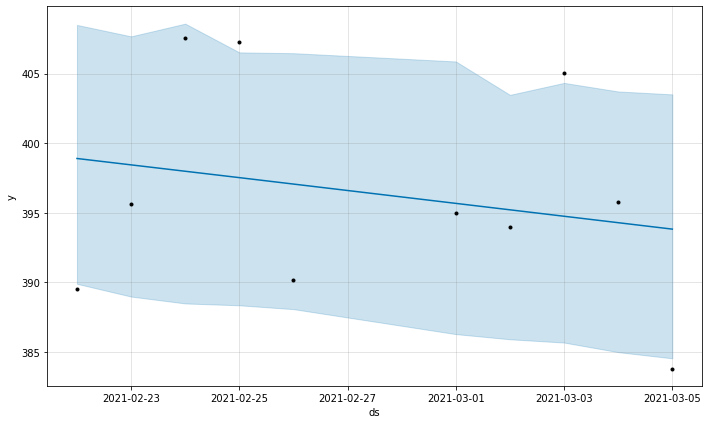

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [398.89914120965284, 398.4405525672069, 397.98196276329116, 397.52335035383976, 397.06069065427, 395.67269836296, 395.21003388364755, 394.7473685864686, 394.2847024403674, 393.82203629426624]
[0, 398.8991, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -0.4585, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 398.4406, 0, -0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, -0.4586, 0, 0.0001, 0, 0, 0, 0, 0, 0]
[4, 397.982, 0, 0.0, 0, -0.0042, 0, 0, 0, 0, 0]
[0, 0, -0.4586, 0, -0.0041, 0, -0.9129, 0, 0, 0, 0]
[6, 397.5234, 0, -0.0041, 0, -0.9171, 0, 4.6018, 0, 0, 0]
[0, 0, -0.4627, 0, -0.9212, 0, 3.6889, 0, -13.8383, 0, 0]
[8, 397.0607, 0, -0.9253, 0, 2.7718, 0, -9.2365, 0, 32.3232, 0]
[0, 0, -1.388, 0, 1.8506, 0, -5.5476, 0, 18.4849, 0, -64.682]
[10, 395.6727, 0, 0.9253, 0, -2.7758, 0, 9.2484, 0, -32.3588, 0]
[0, 0, -0.4627, 0, -0.9252, 0, 3.7008, 0, -13.8739, 0, 0]
[12, 395.21, 0, 0.0001, 0, 0.925, 0, -4.6255, 0, 0, 0]
[0, 0, -0.4626, 0, -0.0002, 0, -0.9247, 0, 0, 0, 0]
[14, 394.7474, 0, -0.0001, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : -4.45615630511464e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 4.45615630511464e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 4.45615630511464e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) - 4.45615630511464e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 4.45615630511464e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 4.45615630511464e-5*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 4.45615630511464e-5*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 4.45615630511464e-5*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000200416666666667*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000200416666666667*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000200416666666667*x*(x/2 - 7)

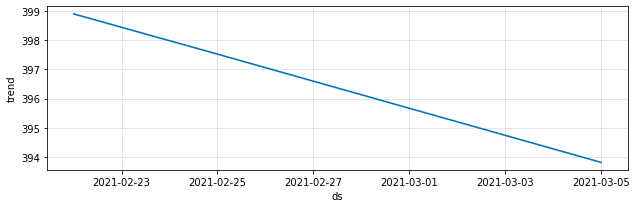

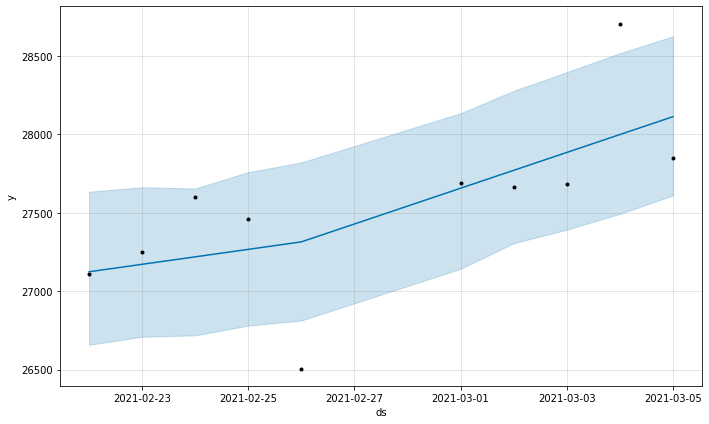

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [27123.997855293324, 27171.63411914591, 27219.270382399838, 27266.906642426427, 27314.6705388174, 27656.88924112113, 27770.962149178416, 27885.035061904433, 27999.107977516385, 28113.180893128338]
[0, 27123.9979, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 47.6362, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 27171.6341, 0, 0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 47.6363, 0, -0.0002, 0, 0, 0, 0, 0, 0]
[4, 27219.2704, 0, -0.0001, 0, 0.128, 0, 0, 0, 0, 0]
[0, 0, 47.6362, 0, 0.1278, 0, 294.0713, 0, 0, 0, 0]
[6, 27266.9066, 0, 0.1277, 0, 294.1993, 0, -1405.1983, 0, 0, 0]
[0, 0, 47.7639, 0, 294.3271, 0, -1111.127, 0, 4083.9995, 0, 0]
[8, 27314.6705, 0, 294.4548, 0, -816.9277, 0, 2678.8012, 0, -9309.3675, 0]
[0, 0, 342.2187, 0, -522.6006, 0, 1567.6742, 0, -5225.368, 0, 18288.3413]
[10, 27656.8892, 0, -228.1458, 0, 750.7465, 0, -2546.5668, 0, 8978.9738, 0]
[0, 0, 114.0729, 0, 228.1459, 0, -978.8926, 0, 3753.6058, 0, 0]
[12, 27770.9621, 0, 0.0001, 0, -228.1461, 0, 1207.039, 0, 0, 0]
[0, 0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.0125994414820326*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.0125994414820326*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.0125994414820326*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.0125994414820326*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.0125994414820326*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.0125994414820326*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.0125994414820326*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.0125994414820326*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.0577217726934524*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.0577217726934524*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.0577217726934524*x*(x/2 - 7)*(x/2 - 6)*(x/2

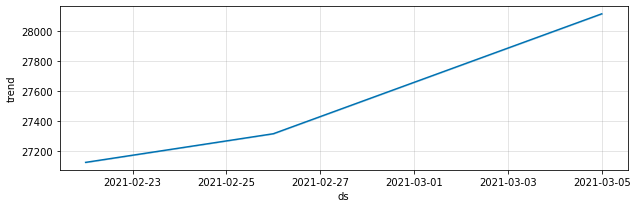

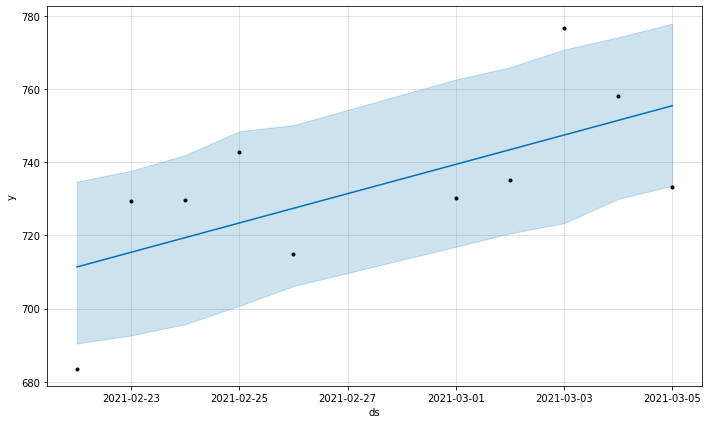

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [711.3686299057628, 715.3731538544127, 719.3776778938031, 723.3821996540397, 727.3867214711295, 739.4002866631886, 743.4048083440875, 747.4093301077331, 751.413851966701, 755.418373825669]
[0, 711.3686, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 4.0046, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 715.3732, 0, -0.0001, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 4.0045, 0, 0.0001, 0, 0, 0, 0, 0, 0]
[4, 719.3777, 0, 0.0, 0, -0.0001, 0, 0, 0, 0, 0]
[0, 0, 4.0045, 0, 0.0, 0, 8.0092, 0, 0, 0, 0]
[6, 723.3822, 0, 0.0, 0, 8.0091, 0, -40.0456, 0, 0, 0]
[0, 0, 4.0045, 0, 8.0091, 0, -32.0364, 0, 120.1366, 0, 0]
[8, 727.3867, 0, 8.0091, 0, -24.0273, 0, 80.091, 0, -280.3185, 0]
[0, 0, 12.0136, 0, -16.0182, 0, 48.0546, 0, -160.1819, 0, 560.6363]
[10, 739.4003, 0, -8.0091, 0, 24.0273, 0, -80.0909, 0, 280.3178, 0]
[0, 0, 4.0045, 0, 8.0091, 0, -32.0363, 0, 120.1359, 0, 0]
[12, 743.4048, 0, 0.0, 0, -8.009, 0, 40.045, 0, 0, 0]
[0, 0, 4.0045, 0, 0.0001, 0, 8.0087, 0, 0, 0, 0]
[14, 747.4093, 0, 0.0001, 0, -0.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.000386240837191358*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000386240837191358*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000386240837191358*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.000386240837191358*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000386240837191358*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000386240837191358*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000386240837191358*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000386240837191358*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.0017380859375*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.0017380859375*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.0017380859375*x*(x/2 - 7)*(x/2 - 

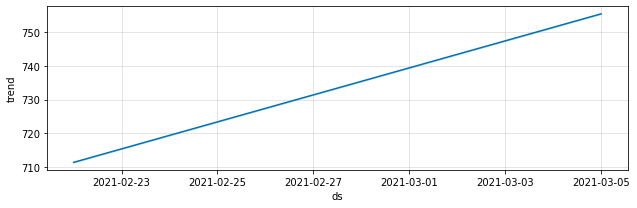

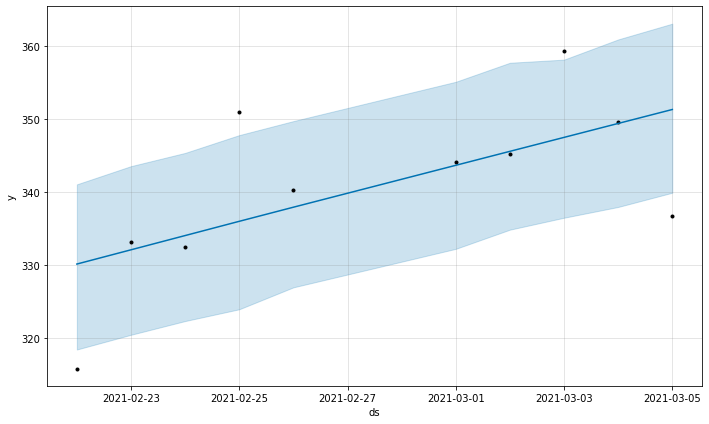

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [330.1726871399405, 332.1256054308822, 334.07852371506885, 336.03144196066125, 337.96440672932056, 343.70807751522864, 345.6226338108876, 347.53423492955005, 349.44583556862335, 351.3574362076967]
[0, 330.1727, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1.9529, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 332.1256, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1.9529, 0, 0.0, 0, 0, 0, 0, 0, 0]
[4, 334.0785, 0, 0.0, 0, -0.0199, 0, 0, 0, 0, 0]
[0, 0, 1.9529, 0, -0.0199, 0, 3.8704, 0, 0, 0, 0]
[6, 336.0314, 0, -0.0199, 0, 3.8505, 0, -19.1914, 0, 0, 0]
[0, 0, 1.933, 0, 3.8306, 0, -15.321, 0, 57.4491, 0, 0]
[8, 337.9644, 0, 3.8107, 0, -11.4705, 0, 38.2577, 0, -133.9331, 0]
[0, 0, 5.7437, 0, -7.6399, 0, 22.9367, 0, -76.484, 0, 267.7535]
[10, 343.7081, 0, -3.8292, 0, 11.4662, 0, -38.2263, 0, 133.8204, 0]
[0, 0, 1.9145, 0, 3.8263, 0, -15.2896, 0, 57.3364, 0, 0]
[12, 345.6226, 0, -0.0029, 0, -3.8234, 0, 19.1101, 0, 0, 0]
[0, 0, 1.9116, 0, 0.0029, 0, 3.8205, 0, 0, 0, 0]
[14, 347.5342, 0, 0.0, 0,

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Derivative of expression with respect to x : 0.000184464216820988*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) + 0.000184464216820988*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) + 0.000184464216820988*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 2)*(x/2 - 1) + 0.000184464216820988*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000184464216820988*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 6)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000184464216820988*x*(x/2 - 8)*(x/2 - 7)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000184464216820988*x*(x/2 - 8)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) + 0.000184464216820988*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2)*(x/2 - 1) - 0.000830438368055556*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 2) - 0.000830438368055556*x*(x/2 - 7)*(x/2 - 6)*(x/2 - 5)*(x/2 - 4)*(x/2 - 3)*(x/2 - 1) - 0.000830438368055556*x*(x

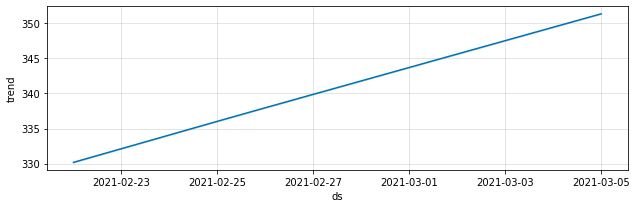

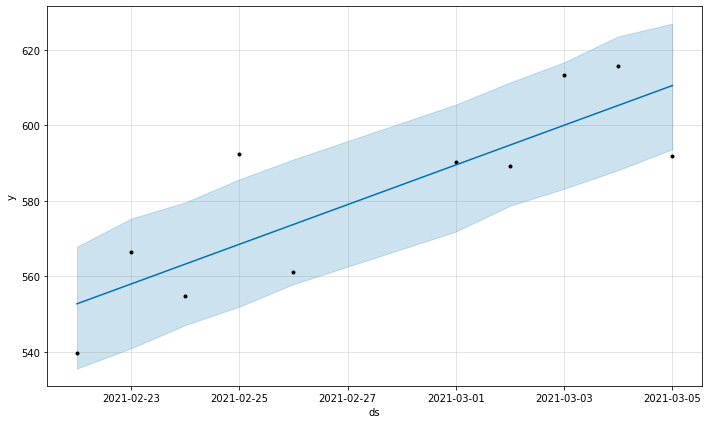

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [552.770619334217, 558.0224178374863, 563.2742163100014, 568.526014997188, 573.7772538945343, 589.5309701870184, 594.7822085337833, 600.0334467701394, 605.2846845403204, 610.5359223105015]
[0, 552.7706, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 5.2518, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 558.0224, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 5.2518, 0, 0.0, 0, 0, 0, 0, 0, 0]
[4, 563.2742, 0, 0.0, 0, -0.0005, 0, 0, 0, 0, 0]
[0, 0, 5.2518, 0, -0.0005, 0, 10.5039, 0, 0, 0, 0]
[6, 568.526, 0, -0.0005, 0, 10.5034, 0, -52.5151, 0, 0, 0]
[0, 0, 5.2513, 0, 10.5029, 0, -42.0112, 0, 157.5415, 0, 0]
[8, 573.7773, 0, 10.5024, 0, -31.5078, 0, 105.0264, 0, -367.5929, 0]
[0, 0, 15.7537, 0, -21.0049, 0, 63.0152, 0, -210.0514, 0, 735.1812]
[10, 589.531, 0, -10.5025, 0, 31.5074, 0, -105.025, 0, 367.5883, 0]
[0, 0, 5.2512, 0, 10.5025, 0, -42.0098, 0, 157.5369, 0, 0]
[12, 594.7822, 0, 0.0, 0, -10.5024, 0, 52.5119, 0, 0, 0]
[0, 0, 5.2512, 0, 0.0001, 0, 10.5021, 0, 0, 0, 0]
[14, 600.0334, 0, 0.00

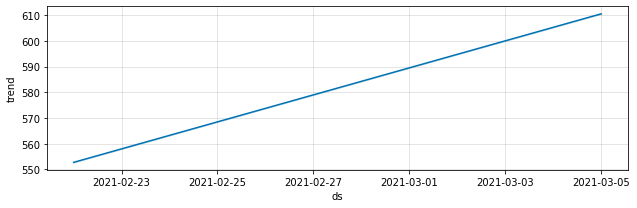

In [61]:
#Prophet by FaceBook
#!pip install fbprophet

call_back = 10
prophet_results = {}
map_prophet = {}
for stock in stocks:
    print()
    print(stock , "*************************")
    print()

    details = db[stock][:call_back].filter(['timestamp','adjusted_close'])

    details.columns = ['ds','y']            #ds and y are fixed names as per prophet documentation
    details['ds'] = pd.to_datetime(details['ds'])

    model = Prophet()

    model.fit(details)

    future = model.make_future_dataframe(periods=0)

    prediction = model.predict(future)
    model.plot(prediction)
    plt.show()
    model.plot_components(prediction)

    #print(prediction)
    workspace = prediction['trend'][-call_back:]
    
    #print(workspace)

    #Newton Forward Interpolation:
    def show(l):
      for i in range(len(l)):
        print(l[i])

    X = []
    Y = [i for i in workspace]
    X = [i for i in range(0,len(workspace)*2 , 2)]
    print(X,Y)
    

    x = symbols('x')
    n = len(workspace) 
    table = [[0 for i in range(n+1)] for j in range(2*n-1)]

    count = 0
    for i in workspace:
      table[count][0] = count
      table[count][1] = round(i,4)
      count+=2

    
    #show(table)
    tmp = 2*(n-1)
    for i in range(n-1):
      col = i + 2
      
      row = i + 1
      while row < tmp:
        #print(row , col)
        table[row][col] = (table[row+1][col-1] - table[row-1][col-1])
        table[row][col] = round(table[row][col],4)
        
        row = row + 2
      tmp = row-2
    show(table)
    expr = 0
    count = 1
    row = 1
    col = 2
    p = x/2
    for i in range(n-1):
      tmp = 1
      for j in range(i+1):
        tmp *= p-j
      #print(j , table[row][col])
      tmp/= math.factorial(j+1)
      expr += tmp * table[row][col]
      row +=1 
      col +=1

    print("Expression : {} ".format(expr))    # + f(0) is missing in this final equation cause we are anyways differentiating it in the next step and f'(constant) = 0 so skip it.
    expr_diff = expr.diff() 

    tmp = expr.replace(x,16) + Y[0]
    #print(tmp)
    print("Derivative of expression with respect to x : {}".format(expr_diff)) 
    ans = expr_diff.replace(x,2*(n-1))

    print("The derivative at terminating date = " , ans)
    map_prophet[stock] = ans
print(map_prophet)


In [ ]:
'''
# BOLLINGER BANDS 
days = 365
gap = days//10
mean = []
upar = []
neeche = []
for i in range(days):
  low = i-gap
  if low<0:
    low = 0
  mean.append(data["adjusted_close"][low:i+gap].mean())
  upar.append(mean[-1] + data["adjusted_close"][low:i+5].std())
  neeche.append(mean[-1] - data["adjusted_close"][low:i+5].std())

list_of_tuples = list(zip(data["timestamp"][:days][::-1], data["adjusted_close"][:days][::-1], mean[::-1], upar[::-1] , neeche[::-1]))  
tmp = pd.DataFrame(list_of_tuples,columns=["time","close","mean",'upar','neeche']  )
tmp.plot(x = "time" , y = ["close","mean",'upar','neeche'])

#SIMILARITY / PAIR TRADING

j = 'ONGC'
days = 365
for i in db.keys():
    if i!=j:
      data1 = db[i]
      data2 = db[j]
      list_of_tuples = list(zip(data1["timestamp"][:days][::-1], data1["log_return"][:days][::-1],data2["log_return"][:days][::-1]))
      
      tmp = pd.DataFrame(list_of_tuples, columns = ["time" , i , j])
      tmp.plot(x = "time" , y = [i,j])
  

SyntaxError: ignored